# Exploración de Archivos JSON en un Directorio y Subdirectorios

Este script en Python recorre un directorio raíz en busca de archivos JSON dentro de todos sus subdirectorios, generando una lista con las rutas de los archivos encontrados.

## 1. **Configuración del Directorio de Búsqueda**
- Se define `root_folder` como el directorio raíz donde se realizará la búsqueda.
- Se usa `os.walk()` para explorar todos los subdirectorios dentro del directorio raíz.

## 2. **Identificación de Archivos JSON**
- En cada subdirectorio, se busca archivos JSON con `glob.glob(os.path.join(dirpath, "*.json"))`.
- Se almacenan las rutas de los archivos encontrados en una lista `all_files`.

## 3. **Conteo y Verificación**
- Se imprime la cantidad total de archivos JSON encontrados.
- Se muestran los primeros archivos de la lista como verificación de que la detección fue exitosa.

## 4. **Aplicaciones del Script**
- Útil para **auditoría y organización** de archivos JSON en estructuras de directorios grandes.
- Se puede usar como **paso previo** antes de procesar datos JSON en análisis o consolidación.

Este enfoque permite obtener una visión rápida de la distribución de archivos JSON antes de realizar operaciones como extracción de datos o limpieza.

In [ ]:
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import os

# Directorio raíz donde buscar archivos JSON
root_folder = "../data/"  # Ajusta según tu estructura

# Lista para almacenar rutas de archivos JSON
all_files = []

# Recorrer todos los directorios y subdirectorios
for dirpath, _, filenames in os.walk(root_folder):
    # Buscar archivos JSON en cada directorio
    json_files = glob.glob(os.path.join(dirpath, "*.json"))
    all_files.extend(json_files)

# Mostrar cantidad de archivos encontrados
print(f"Se encontraron {len(all_files)} archivos JSON.")
print(all_files[:5])  # Muestra los primeros archivos para verificar


# Carga y Análisis de Archivos JSON de Metadatos y Reseñas

Este script en Python realiza la exploración y procesamiento de archivos JSON dentro de **directorios de metadatos** y **directorios de reseñas**, asegurando una carga robusta y manejando errores comunes.

## 1. **Búsqueda y Listado de Archivos JSON**
- Se recorren los directorios de **metadatos de sitios** (`metadata_dir`) y **reseñas por estado** (`reviews_root_dir`).
- Se usa `glob.glob()` para identificar archivos JSON de metadatos.
- Se emplea `os.walk()` para buscar archivos JSON de reseñas en subdirectorios.

## 2. **Carga Robustecida de Archivos JSON**
- Se define la función `cargar_json_robustamente()` para manejar:
  - Decodificación correcta de archivos JSON.
  - Corrección de errores de formato como saltos de línea (`\r\n → \n`).
  - Procesamiento de archivos con múltiples objetos JSON en una sola línea o concatenados.
  - Inclusión de etiquetas de estado en los datos procesados.

## 3. **Selección de Archivos a Procesar**
- Se permite al usuario seleccionar manualmente archivos de **metadatos** y **reseñas** mediante `input()`, con opción de procesar **todos** o solo uno específico.
- Se validan los valores ingresados para evitar errores.

## 4. **Creación de DataFrames y Exploración de Datos**
- Se estructura la información en `Pandas.DataFrame()`.
- Se imprimen muestras (`df.head()`) y estadísticas descriptivas (`df.describe()`) para revisión inicial de los datos.
- Se identifica si hubo archivos con errores de lectura.

## 5. **Detección de Problemas y Reporte**
- Se muestra un listado de archivos JSON con errores.
- Se maneja adecuadamente la ausencia de datos (`if lista_metadata:` y `if lista_reviews:`).
- Se sugieren futuras exploraciones de datos (`EDA específico para metadatos y reseñas`).

Este script es fundamental para **inspeccionar y organizar** archivos JSON en proyectos de análisis de datos, asegurando la **integridad** de la información antes de aplicar métodos más avanzados.

In [ ]:
# Directorios raíz donde buscar archivos JSON
metadata_dir = "../data/google_maps/metadata-sitios"
reviews_root_dir = "../data/google_maps/reviews-estados"

metadata_files = glob.glob(os.path.join(metadata_dir, "*.json"))
reviews_files = []
for dirpath, _, filenames in os.walk(reviews_root_dir):
    for filename in filenames:
        if filename.endswith(".json"):
            reviews_files.append(os.path.join(dirpath, filename))

print(f"Se encontraron {len(metadata_files)} archivos de metadatos de sitios.")
print(f"Se encontraron {len(reviews_files)} archivos de reseñas.")

lista_metadata = []
metadata_errores = []
lista_reviews = []
reviews_errores = []

def cargar_json_robustamente(archivo, lista_destino, lista_errores, estado=None):
    """
    Intenta cargar uno o más objetos JSON desde un archivo, manejando errores comunes.
    """
    try:
        with open(archivo, 'r', encoding='utf-8') as f:
            contenido = f.read()
            # Reemplazar saltos de línea de Windows (CR LF) con saltos de línea Unix (\n)
            contenido = contenido.replace('\r\n', '\n')
            try:
                # Intenta cargar como un solo objeto JSON
                data = json.loads(contenido)
                if estado:
                    data['state'] = estado
                lista_destino.append(data)
            except json.JSONDecodeError as e_single:
                print(f"Error al decodificar JSON único (UTF-8) en {archivo}: {e_single}")
                try:
                    # Intenta cargar como múltiples objetos JSON concatenados
                    objetos = contenido.strip().split('\n')
                    for i, obj_str in enumerate(objetos):
                        if obj_str.strip():
                            try:
                                data = json.loads(obj_str)
                                if estado:
                                    data['state'] = estado
                                lista_destino.append(data)
                            except json.JSONDecodeError as e_multi:
                                print(
                                    f"Error al decodificar objeto JSON individual (UTF-8) en {archivo}, línea {i + 1}: {e_multi} - Se ignorará la línea.")
                                lista_errores.append(archivo)
                except Exception as e_multi_split:
                    print(
                        f"Error al intentar dividir el archivo en múltiples objetos JSON: {e_multi_split}")
                    lista_errores.append(archivo)
    except FileNotFoundError:
        print(f"Error: El archivo {archivo} no fue encontrado.")
        lista_errores.append(archivo)
    except Exception as e_general:
        print(f"Error general al leer el archivo {archivo}: {e_general}")
        lista_errores.append(archivo)

# Pedir al usuario el número de archivo a procesar
while True:
    try:
        metadata_index = int(input(
            f"Ingrese el número de archivo a procesar de metadatos (1-{len(metadata_files)}, 0 para todos): "))
        if 0 <= metadata_index <= len(metadata_files):
            break
        else:
            print("Número de archivo inválido. Por favor, ingrese un número dentro del rango válido.")
    except ValueError:
        print("Entrada inválida. Por favor, ingrese un número entero.")

while True:
    try:
        reviews_index = int(input(
            f"Ingrese el número de archivo a procesar de reseñas (1-{len(reviews_files)}, 0 para todos): "))
        if 0 <= reviews_index <= len(reviews_files):
            break
        else:
            print("Número de archivo inválido. Por favor, ingrese un número dentro del rango válido.")
    except ValueError:
        print("Entrada inválida. Por favor, ingrese un número entero.")

# Cargar metadatos de sitios
if metadata_index == 0:
    for archivo in metadata_files:
        cargar_json_robustamente(archivo, lista_metadata, metadata_errores)
else:
    archivo = metadata_files[metadata_index - 1]
    cargar_json_robustamente(archivo, lista_metadata, metadata_errores)

# Cargar reseñas
if reviews_index == 0:
    for archivo in reviews_files:
        cargar_json_robustamente(archivo, lista_reviews, reviews_errores)
else:
    archivo = reviews_files[reviews_index - 1]
    cargar_json_robustamente(archivo, lista_reviews, reviews_errores)

print("\n--- Metadatos de Sitios ---")
if lista_metadata:
    df_metadata = pd.DataFrame(lista_metadata)
    print(df_metadata.head())
    print(df_metadata.describe())
    # ... (Aquí puedes agregar EDA específico para metadatos)
else:
    print("No se cargaron datos de metadatos de sitios.")
if metadata_errores:
    print("\nArchivos de metadatos con errores:")
    for archivo in metadata_errores:
        print(archivo)

print("\n--- Reseñas ---")
if lista_reviews:
    df_reviews = pd.DataFrame(lista_reviews)
    print(df_reviews.head())
    print(df_reviews.describe())
    # ... (Aquí puedes agregar EDA específico para reseñas)
else:
    print("No se cargaron datos de reseñas.")
if reviews_errores:
    print("\nArchivos de reseñas con errores:")
    for archivo in reviews_errores:
        print(archivo)

Se encontraron 11 archivos de metadatos de sitios.
Se encontraron 611 archivos de reseñas.
Error al decodificar JSON único (UTF-8) en ../data/google_maps/metadata-sitios\1.json: Extra data: line 2 column 1 (char 1055)
Error al decodificar JSON único (UTF-8) en ../data/google_maps/reviews-estados\review-Alabama\1.json: Extra data: line 2 column 1 (char 291)

--- Metadatos de Sitios ---
               name                                            address  \
0   Porter Pharmacy  Porter Pharmacy, 129 N Second St, Cochran, GA ...   
1      City Textile  City Textile, 3001 E Pico Blvd, Los Angeles, C...   
2      San Soo Dang  San Soo Dang, 761 S Vermont Ave, Los Angeles, ...   
3      Nova Fabrics  Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...   
4  Nobel Textile Co  Nobel Textile Co, 719 E 9th St, Los Angeles, C...   

                                 gmap_id description   latitude   longitude  \
0  0x88f16e41928ff687:0x883dad4fd048e8f8        None  32.388300  -83.357100   
1  0x80c2

# Carga y Conversión de Archivos JSON a Parquet con Manejo de Errores

Este script en Python explora directorios de archivos JSON, los carga con una estrategia robusta y los convierte en archivos Parquet, optimizando el almacenamiento y procesamiento de datos.

## 1. **Exploración y Listado de Archivos JSON**
- Se define `metadata_dir` y `reviews_root_dir` como directorios de metadatos y reseñas, respectivamente.
- Se usa `glob.glob()` para identificar archivos JSON de metadatos.
- `os.walk()` recorre todos los subdirectorios en `reviews_root_dir` buscando archivos JSON de reseñas.

## 2. **Carga de Archivos JSON con Manejo de Errores**
- Se define `cargar_json_robustamente()`, que:
  - Intenta cargar archivos JSON correctamente, manejando problemas de codificación.
  - Corrige formatos irregulares reemplazando saltos de línea (`\r\n` → `\n`).
  - Detecta si el archivo contiene múltiples objetos JSON concatenados y los procesa individualmente.
  - Asigna una etiqueta de estado a los datos de reseñas.
- Se registra cualquier error en listas de seguimiento (`metadata_errores`, `reviews_errores`).

## 3. **Conversión de Datos a Parquet**
- La función `crear_parquet_con_manejo_de_errores()`:
  - Convierte listas de diccionarios en `DataFrame` de `Pandas`.
  - Guarda cada archivo en formato **Parquet**, optimizando el almacenamiento.
  - Maneja errores durante la conversión e informa si algún archivo no tiene datos válidos.

## 4. **Procesamiento Secuencial**
- Se recorren los archivos de metadatos y reseñas aplicando:
  - Carga y validación de datos.
  - Conversión a Parquet con nombres estructurados (`metadata_sitios_<archivo>.parquet`, `reviews_<archivo>.parquet`).
  - Registro de archivos problemáticos.

## 5. **Reporte de Archivos con Errores**
- Se imprime una lista de archivos que tuvieron problemas de carga.
- Se proporciona un resumen del proceso ejecutado.

## 6. **Aplicaciones del Script**
- **Optimiza la exploración y procesamiento** de grandes volúmenes de archivos JSON.
- **Reduce espacio de almacenamiento y mejora el rendimiento** al convertir los datos a **Parquet**.
- **Detecta y corrige errores** en archivos JSON antes de integrarlos en flujos de datos más avanzados.

Este script es esencial para la limpieza, inspección y consolidación de datos en proyectos de análisis estructurado.

In [1]:
import json
import pandas as pd
import os
import glob

# Directorios raíz donde buscar archivos JSON
metadata_dir = "../data/google_maps/metadata-sitios"
reviews_root_dir = "../data/google_maps/reviews-estados"
parquet_dir = "../data/parquet_files"
os.makedirs(parquet_dir, exist_ok=True)  # Crea el directorio si no existe

metadata_files = glob.glob(os.path.join(metadata_dir, "*.json"))
reviews_files = []
for dirpath, _, filenames in os.walk(reviews_root_dir):
    for filename in filenames:
        if filename.endswith(".json"):
            reviews_files.append(os.path.join(dirpath, filename))

print(f"Se encontraron {len(metadata_files)} archivos de metadatos de sitios.")
print(f"Se encontraron {len(reviews_files)} archivos de reseñas.")

metadata_errores = []
reviews_errores = []

def cargar_json_robustamente(archivo, estado=None):
    """
    Intenta cargar uno o más objetos JSON desde un archivo, manejando errores comunes.
    Args:
        archivo (str): La ruta al archivo JSON.
        estado (str, opcional): El estado asociado con los datos (para archivos de reseñas).
    Returns:
        list: Una lista de diccionarios con los datos cargados, o None si hay un error.
    """
    lista_datos = []
    try:
        with open(archivo, 'r', encoding='utf-8') as f:
            contenido = f.read()
            # Reemplazar saltos de línea de Windows (CR LF) con saltos de línea Unix (\n)
            contenido = contenido.replace('\r\n', '\n')
            try:
                # Intenta cargar como un solo objeto JSON
                data = json.loads(contenido)
                if estado:
                    data['state'] = estado  # Agrega el estado si está disponible
                lista_datos.append(data)
            except json.JSONDecodeError as e_single:
                print(f"Error al decodificar JSON único (UTF-8) en {archivo}: {e_single}")
                try:
                    # Intenta cargar como múltiples objetos JSON concatenados
                    objetos = contenido.strip().split('\n')
                    for i, obj_str in enumerate(objetos):
                        if obj_str.strip():
                            try:
                                data = json.loads(obj_str)
                                if estado:
                                    data['state'] = estado  # Agrega el estado a cada objeto
                                lista_datos.append(data)
                            except json.JSONDecodeError as e_multi:
                                print(
                                    f"Error al decodificar objeto JSON individual (UTF-8) en {archivo}, línea {i + 1}: {e_multi} - Se ignorará la línea.")
                                lista_errores.append(archivo)
                except Exception as e_multi_split:
                    print(
                        f"Error al intentar dividir el archivo en múltiples objetos JSON: {e_multi_split}")
                    lista_errores.append(archivo)
    except FileNotFoundError:
        print(f"Error: El archivo {archivo} no fue encontrado.")
        lista_errores.append(archivo)
    except Exception as e_general:
        print(f"Error general al leer el archivo {archivo}: {e_general}")
        lista_errores.append(archivo)
    return lista_datos

def crear_parquet_con_manejo_de_errores(lista_datos, nombre_archivo, parquet_dir):
    """
    Crea un archivo Parquet a partir de una lista de datos, manejando errores.
    Args:
        lista_datos (list): Lista de diccionarios con los datos.
        nombre_archivo (str): Nombre del archivo Parquet a crear.
        parquet_dir (str): Directorio donde se guardará el archivo Parquet.
    """
    if lista_datos:
        try:
            df = pd.DataFrame(lista_datos)
            parquet_file = os.path.join(parquet_dir, nombre_archivo)
            df.to_parquet(parquet_file)
            print(f"Guardado en: {parquet_file}")
        except Exception as e:
            print(f"Error al crear el archivo Parquet {nombre_archivo}: {e}")
    else:
        print(f"No hay datos para guardar en {nombre_archivo}")

# Procesar metadatos secuencialmente
for archivo in metadata_files:
    lista_metadata = cargar_json_robustamente(archivo)
    if lista_metadata:
        crear_parquet_con_manejo_de_errores(lista_metadata, f"metadata_sitios_{os.path.basename(archivo).replace('.json', '.parquet')}", parquet_dir)
    else:
        print(f"No se pudieron cargar datos de {archivo}")

# Procesar reseñas secuencialmente
for archivo in reviews_files:
    estado = os.path.basename(os.path.dirname(archivo))
    lista_reviews = cargar_json_robustamente(archivo, estado=estado)
    if lista_reviews:
        crear_parquet_con_manejo_de_errores(lista_reviews, f"reviews_{os.path.basename(archivo).replace('.json', '.parquet')}", parquet_dir)
    else:
        print(f"No se pudieron cargar datos de {archivo}")

if metadata_errores:
    print("\nArchivos de metadatos con errores:")
    for archivo in metadata_errores:
        print(archivo)

if reviews_errores:
    print("\nArchivos de reseñas con errores:")
    for archivo in reviews_errores:
        print(archivo)


Se encontraron 11 archivos de metadatos de sitios.
Se encontraron 611 archivos de reseñas.
Error al decodificar JSON único (UTF-8) en ../data/google_maps/metadata-sitios\1.json: Extra data: line 2 column 1 (char 1055)
Guardado en: ../data/parquet_files\metadata_sitios_1.parquet
Error al decodificar JSON único (UTF-8) en ../data/google_maps/metadata-sitios\10.json: Extra data: line 2 column 1 (char 1055)
Guardado en: ../data/parquet_files\metadata_sitios_10.parquet
Error al decodificar JSON único (UTF-8) en ../data/google_maps/metadata-sitios\11.json: Extra data: line 2 column 1 (char 1055)
Guardado en: ../data/parquet_files\metadata_sitios_11.parquet
Error al decodificar JSON único (UTF-8) en ../data/google_maps/metadata-sitios\2.json: Extra data: line 2 column 1 (char 1055)
Guardado en: ../data/parquet_files\metadata_sitios_2.parquet
Error al decodificar JSON único (UTF-8) en ../data/google_maps/metadata-sitios\3.json: Extra data: line 2 column 1 (char 1055)
Guardado en: ../data/parqu

Proceso de conversión y organización de datos desde archivos JSON a archivos Parquet, diseñado para manejar datos de Google Maps (metadatos de sitios y reseñas):

**1\. Importación de Bibliotecas:**

*   **json**: Para trabajar con datos en formato JSON.
    
*   **pandas**: Para manejar los datos en DataFrames, lo que permite una manipulación y análisis eficientes.
    
*   **os**: Para operaciones relacionadas con el sistema operativo, como la creación de directorios y la manipulación de rutas de archivos.
    
*   **glob**: Para buscar archivos que coincidan con un patrón específico.
    
*   **pyarrow.parquet**: Para leer y escribir archivos en formato Parquet, un formato de almacenamiento columnar eficiente.
    
*   **pyarrow as pa**: Importa el módulo pyarrow para trabajar con tablas de datos de manera eficiente.
    

**2\. Definición de Rutas de Directorios:**

*   Se definen las rutas donde se encuentran los archivos JSON de metadatos de sitios y reseñas, así como la ruta donde se guardarán los archivos Parquet convertidos.
    
*   Se crea el directorio para los archivos Parquet si no existe.
    

**3\. Búsqueda de Archivos JSON:**

*   Se utilizan glob.glob() y os.walk() para encontrar todos los archivos JSON dentro de los directorios de metadatos y reseñas.
    
*   Se imprime la cantidad de archivos de metadatos y reseñas encontrados.
    

4\. Función cargar\_json\_robustamente:

*   Esta función intenta cargar datos JSON desde un archivo, manejando varios errores potenciales:
    
    *   FileNotFoundError: Si el archivo no se encuentra.
        
    *   json.JSONDecodeError: Si el archivo no es un JSON válido.
        
    *   Otros errores generales al leer el archivo.
        
*   Reemplaza los saltos de línea de Windows (\\r\\n) por saltos de línea Unix (\\n).
    
*   Intenta cargar el archivo como un solo objeto JSON y, si falla, intenta cargarlo como múltiples objetos JSON separados por saltos de línea.
    
*   Si se proporciona un estado, se agrega este al diccionario de datos.
    
*   Devuelve una lista de diccionarios con los datos cargados o None si hay un error.
    

5\. Función json\_a\_parquet:

*   Convierte un archivo JSON a un archivo Parquet.
    
*   Utiliza cargar\_json\_robustamente para cargar los datos JSON.
    
*   Crea un DataFrame de pandas con los datos y lo guarda como un archivo Parquet.
    
*   Imprime un mensaje de éxito o error.
    
*   Devuelve True si la conversión es exitosa, False en caso contrario.
    

6\. Función combinar\_parquet:

*   Combina múltiples archivos Parquet en uno solo.
    
*   Lee los archivos Parquet de entrada utilizando pq.read\_table().
    
*   Concatena las tablas de datos en una sola tabla.
    
*   Escribe la tabla combinada en un nuevo archivo Parquet.
    
*   Imprime un mensaje de éxito o error.
    

**7\. Conversión de Metadatos a Parquet:**

*   Itera sobre los archivos de metadatos JSON.
    
*   Convierte cada archivo JSON a un archivo Parquet individual utilizando json\_a\_parquet.
    
*   Almacena las rutas de los archivos Parquet de metadatos creados.
    
*   Combina todos los archivos Parquet de metadatos en un solo archivo Parquet usando combinar\_parquet.
    
*   Elimina los archivos Parquet individuales de metadatos después de la combinación.
    

**8\. Conversión de Reseñas a Parquet:**

*   Itera sobre los archivos de reseñas JSON.
    
*   Convierte cada archivo JSON a un archivo Parquet individual, incluyendo el estado en el nombre del archivo.
    
*   Almacena las rutas de los archivos Parquet de reseñas creados.
    
*   Combina los archivos Parquet de reseñas por estado en archivos Parquet separados para cada estado.
    
*   Elimina los archivos Parquet individuales de reseñas después de la combinación por estados.
    

**9\. Manejo de Errores:**

*   Imprime los archivos que no se pudieron convertir a Parquet debido a errores.
    

En resumen, este código toma datos de Google Maps en formato JSON y los convierte a un formato Parquet más eficiente, organizando los datos de reseñas por estado. Esto facilita el almacenamiento y procesamiento de grandes cantidades de datos de manera más efectiva.

In [ ]:
import json
import pandas as pd
import os
import glob
import pyarrow.parquet as pq  # Importa pyarrow.parquet
import pyarrow as pa

# Directorios raíz donde buscar archivos JSON
metadata_dir = "../data/google_maps/metadata-sitios"
reviews_root_dir = "../data/google_maps/reviews-estados"
parquet_dir = "../data/parquet_files"
os.makedirs(parquet_dir, exist_ok=True)  # Crea el directorio si no existe

metadata_files = glob.glob(os.path.join(metadata_dir, "*.json"))
reviews_files = []
for dirpath, _, filenames in os.walk(reviews_root_dir):
    for filename in filenames:
        if filename.endswith(".json"):
            reviews_files.append(os.path.join(dirpath, filename))

print(f"Se encontraron {len(metadata_files)} archivos de metadatos de sitios.")
print(f"Se encontraron {len(reviews_files)} archivos de reseñas.")

metadata_errores = []
reviews_errores = []

def cargar_json_robustamente(archivo, estado=None):
    """
    Intenta cargar uno o más objetos JSON desde un archivo, manejando errores comunes.
    Args:
        archivo (str): La ruta al archivo JSON.
        estado (str, opcional): El estado asociado con los datos (para archivos de reseñas).
    Returns:
        list: Una lista de diccionarios con los datos cargados, o None si hay un error.
    """
    lista_datos = []
    try:
        with open(archivo, 'r', encoding='utf-8') as f:
            contenido = f.read()
            # Reemplazar saltos de línea de Windows (CR LF) con saltos de línea Unix (\n)
            contenido = contenido.replace('\r\n', '\n')
            try:
                # Intenta cargar como un solo objeto JSON
                data = json.loads(contenido)
                if estado:
                    data['state'] = estado  # Agrega el estado si está disponible
                lista_datos.append(data)
            except json.JSONDecodeError as e_single:
                print(f"Error al decodificar JSON único (UTF-8) en {archivo}: {e_single}")
                try:
                    # Intenta cargar como múltiples objetos JSON concatenados
                    objetos = contenido.strip().split('\n')
                    for i, obj_str in enumerate(objetos):
                        if obj_str.strip():
                            try:
                                data = json.loads(obj_str)
                                if estado:
                                    data['state'] = estado  # Agrega el estado a cada objeto
                                lista_datos.append(data)
                            except json.JSONDecodeError as e_multi:
                                print(
                                    f"Error al decodificar objeto JSON individual (UTF-8) en {archivo}, línea {i + 1}: {e_multi} - Se ignorará la línea.")
                                lista_errores.append(archivo)
                except Exception as e_multi_split:
                    print(
                        f"Error al intentar dividir el archivo en múltiples objetos JSON: {e_multi_split}")
                    lista_errores.append(archivo)
    except FileNotFoundError:
        print(f"Error: El archivo {archivo} no fue encontrado.")
        lista_errores.append(archivo)
    except Exception as e_general:
        print(f"Error general al leer el archivo {archivo}: {e_general}")
        lista_errores.append(archivo)
    return lista_datos

def json_a_parquet(archivo_json, archivo_parquet, estado=None):
    """
    Convierte un archivo JSON a un archivo Parquet.
    Args:
        archivo_json (str): La ruta al archivo JSON de entrada.
        archivo_parquet (str): La ruta al archivo Parquet de salida.
        estado (str, opcional): El estado asociado con los datos (para archivos de reseñas).
    """
    datos = cargar_json_robustamente(archivo_json, estado=estado)
    if datos:
        try:
            df = pd.DataFrame(datos)
            df.to_parquet(archivo_parquet)
            print(f"Convertido: {archivo_json} a {archivo_parquet}")
        except Exception as e:
            print(f"Error al convertir {archivo_json} a Parquet: {e}")
            return False  # Indica que hubo un error
        return True  # Indica que la conversión fue exitosa
    else:
        print(f"No se pudieron cargar datos de {archivo_json}")
        return False  # Indica que hubo un error


def combinar_parquet(archivos_parquet, archivo_salida):
    """
    Combina múltiples archivos Parquet en uno solo, compatible con versiones anteriores de pyarrow.
    Args:
        archivos_parquet (list): Lista de rutas a los archivos Parquet de entrada.
        archivo_salida (str): La ruta al archivo Parquet de salida combinado.
    """
    if archivos_parquet:
        try:
            # Leer el primer archivo Parquet para inicializar la tabla combinada
            combined_table = pq.read_table(archivos_parquet[0])
            # Iterar sobre los archivos restantes y concatenarlos
            for archivo in archivos_parquet[1:]:
                table = pq.read_table(archivo)
                # Unificar esquemas antes de concatenar
                combined_table = combined_table.cast(table.schema)
                combined_table = pa.concat_tables([combined_table, table])
            # Escribir la tabla combinada al archivo de salida
            pq.write_table(combined_table, archivo_salida)
            print(f"Combinados: {len(archivos_parquet)} archivos en {archivo_salida}")
        except Exception as e:
            print(f"Error al combinar archivos Parquet: {e}")
    else:
        print("No hay archivos Parquet para combinar.")

# Convertir metadatos a Parquet individualmente
archivos_parquet_metadata = []
for archivo in metadata_files:
    archivo_parquet = os.path.join(parquet_dir,
                                   f"metadata_sitios_{os.path.basename(archivo).replace('.json', '.parquet')}")
    if json_a_parquet(archivo, archivo_parquet):
        archivos_parquet_metadata.append(archivo_parquet)

# Combinar archivos Parquet de metadatos
archivo_salida_metadata = os.path.join(parquet_dir, "metadata_sitios_All.parquet")
if archivos_parquet_metadata:
    combinar_parquet(archivos_parquet_metadata, archivo_salida_metadata)
    # Eliminar archivos Parquet de metadatos individuales después de combinarlos
    for archivo_para_eliminar in archivos_parquet_metadata:
        try:
            os.remove(archivo_para_eliminar)
            print(f"Eliminado: {archivo_para_eliminar}")
        except Exception as e:
            print(f"Error al eliminar {archivo_para_eliminar}: {e}")
else:
    print("No hay archivos de metadatos para combinar.")

# Convertir reseñas a Parquet individualmente
archivos_parquet_reviews = []
estados_procesados = set()  # Para evitar procesar el mismo estado múltiples veces
for archivo in reviews_files:
    estado = os.path.basename(os.path.dirname(archivo)).replace("review-", "")  # Obtiene el estado del directorio
    archivo_parquet = os.path.join(parquet_dir,
                                   f"reviews_{estado}_{os.path.basename(archivo).replace('.json', '.parquet')}")  # Incluye el estado en el nombre del archivo
    if json_a_parquet(archivo, archivo_parquet, estado=estado):
        archivos_parquet_reviews.append(archivo_parquet)
    estados_procesados.add(estado)

# Combinar archivos Parquet por estado
for estado in estados_procesados:
    archivos_para_combinar = [archivo for archivo in archivos_parquet_reviews if f"reviews_{estado}_" in archivo]
    if archivos_para_combinar:
        archivo_salida = os.path.join(parquet_dir, f"reviews_{estado}_All.parquet")
        combinar_parquet(archivos_para_combinar, archivo_salida)
        # Eliminar archivos Parquet individuales después de combinarlos
        for archivo_para_eliminar in archivos_para_combinar:
            try:
                os.remove(archivo_para_eliminar)
                print(f"Eliminado: {archivo_para_eliminar}")
            except Exception as e:
                print(f"Error al eliminar {archivo_para_eliminar}: {e}")

if metadata_errores:
    print("\nArchivos de metadatos con errores:")
    for archivo in metadata_errores:
        print(archivo)

if reviews_errores:
    print("\nArchivos de reseñas con errores:")
    for archivo in reviews_errores:
        print(archivo)


Sealiza un Análisis Exploratorio de Datos (EDA) básico en archivos Parquet ubicados en un directorio específico. Aquí está el desglose de lo que hace el código:

**1\. Importación de Bibliotecas:**

*   **pandas**: Para la manipulación y análisis de datos, especialmente para leer los archivos Parquet en DataFrames.
    
*   **os**: Para interactuar con el sistema operativo, como la manipulación de rutas de archivos.
    
*   **glob**: Para buscar archivos que coincidan con un patrón específico (en este caso, archivos Parquet).
    
*   **matplotlib.pyplot**: Para la visualización de datos, como la generación de histogramas y gráficos de dispersión.
    
*   **seaborn**: Una biblioteca de visualización de datos basada en matplotlib que proporciona una interfaz de alto nivel para crear gráficos atractivos.
    
*   %matplotlib inline: Esta línea es específica de Jupyter Notebook. Permite que los gráficos generados por matplotlib se muestren directamente en el notebook. Si estás ejecutando el código en un entorno diferente, como un script de Python normal, esta línea no es necesaria.
    

**2\. Definición del Directorio Parquet:**

*   Se define la variable parquet\_dir para almacenar la ruta al directorio que contiene los archivos Parquet que se van a analizar. En este caso, la ruta es "../data/parquet\_files".
    

3\. Función realizar\_eda\_parquet(directorio):

*   Esta función realiza el EDA en los archivos Parquet del directorio especificado.
    
    *   **Obtención de archivos Parquet:**
        
        *   Utiliza glob.glob() para obtener una lista de todos los archivos con la extensión ".parquet" en el directorio proporcionado.
            
    *   **Verificación de archivos:**
        
        *   Si no se encuentran archivos Parquet, se imprime un mensaje y la función termina.
            
    *   **Iteración sobre archivos Parquet:**
        
        *   La función itera sobre cada archivo Parquet encontrado.
            
        *   Para cada archivo, se realiza lo siguiente:
            
            *   **Lectura del archivo Parquet:**
                
                *   Utiliza pd.read\_parquet() para leer el archivo Parquet y cargarlo en un DataFrame de pandas.
                    
            *   **Manejo de Excepciones:**
                
                *   El código está dentro de un bloque try...except para capturar cualquier error que pueda ocurrir al procesar un archivo Parquet. Si ocurre un error, se imprime un mensaje de error y el bucle continúa con el siguiente archivo.
                    
            *   **Impresión de información general:**
                
                *   df.info(): Imprime información sobre el DataFrame, como el tipo de datos de las columnas, el número de filas y columnas, y el uso de memoria.
                    
            *   **Impresión de las primeras filas:**
                
                *   df.head(): Imprime las primeras 5 filas del DataFrame para dar una idea del contenido de los datos.
                    
                *   Antes de imprimir el DataFrame, el código verifica si alguna de las celdas contiene un objeto pd.Series o un diccionario. Si es así, convierte el objeto a una lista o un diccionario estándar de Python, respectivamente. Esto asegura que el DataFrame se pueda imprimir correctamente.
                    
                *   df.to\_markdown(): Imprime las primeras 5 filas del DataFrame en formato Markdown, lo que facilita la lectura en la consola.
                    
            *   **Impresión de estadísticas descriptivas:**
                
                *   df.describe(): Imprime estadísticas descriptivas de las columnas numéricas del DataFrame, como la media, la desviación estándar, el mínimo, el máximo y los cuartiles.
                    
                *   df.describe().to\_markdown(): Imprime las estadísticas descriptivas en formato Markdown.
                    
            *   **Impresión de valores únicos de columnas no numéricas:**
                
                *   Itera sobre las columnas del DataFrame.
                    
                *   Para cada columna que no es numérica, imprime el número de valores únicos en esa columna. Esto ayuda a comprender la distribución de los datos categóricos.
                    
                *   Al igual que con df.head(), el código verifica si alguna de las celdas contiene un objeto pd.Series o un diccionario y, de ser así, lo convierte a una lista o un diccionario estándar de Python antes de imprimir el número de valores únicos.
                    
            *   **Generación de histogramas para columnas numéricas:**
                
                *   Itera sobre las columnas numéricas del DataFrame.
                    
                *   Para cada columna numérica, genera un histograma utilizando sns.histplot().
                    
                *   El histograma muestra la distribución de los valores en la columna.
                    
                *   plt.title(): Establece el título del gráfico.
                    
                *   plt.xlabel() y plt.ylabel(): Establecen las etiquetas de los ejes x e y.
                    
                *   plt.show(): Muestra el gráfico.
                    
            *   **Generación de gráficos de dispersión para pares de columnas numéricas:**
                
                *   Genera gráficos de dispersión para visualizar la relación entre pares de columnas numéricas.
                    
                *   Si hay más de una columna numérica, itera sobre todos los pares posibles de columnas numéricas.
                    
                *   Para cada par de columnas, genera un gráfico de dispersión utilizando sns.scatterplot().
                    
                *   plt.title(): Establece el título del gráfico.
                    
                *   plt.xlabel() y plt.ylabel(): Establecen las etiquetas de los ejes x e y.
                    
                *   plt.show(): Muestra el gráfico.
                    
                *   Si no hay suficientes columnas numéricas, se imprime un mensaje indicando que no se pueden generar gráficos de dispersión.
                    

**4\. Ejecución del EDA:**

*   Finalmente, se llama a la función realizar\_eda\_parquet() con el directorio de archivos Parquet definido anteriormente para realizar el EDA.
    

En resumen, este código automatiza el proceso de realizar un EDA básico en un conjunto de archivos Parquet. Proporciona información general sobre los datos, muestra estadísticas descriptivas, imprime valores únicos para columnas no numéricas y genera visualizaciones útiles como histogramas y gráficos de dispersión. Esto puede ser muy útil para comprender rápidamente las características y la distribución de los datos en archivos Parquet.

In [ ]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Agrega esta línea para que los gráficos se muestren en Jupyter Notebook
# Si estás ejecutando el script en VS Code, esta línea no afectará el comportamiento.
%matplotlib inline

parquet_dir = "../data/parquet_files"

def realizar_eda_parquet(directorio):
    """
    Realiza un Análisis Exploratorio de Datos (EDA) básico en archivos Parquet.

    Args:
        directorio (str): Directorio que contiene los archivos Parquet.
    """
    # Obtener todos los archivos Parquet en el directorio
    archivos_parquet = glob.glob(os.path.join(directorio, "*.parquet"))

    if not archivos_parquet:
        print("No se encontraron archivos Parquet en el directorio especificado.")
        return

    for archivo in archivos_parquet:
        print(f"\nAnálisis del archivo: {archivo}")
        try:
            # Leer el archivo Parquet en un DataFrame de pandas
            df = pd.read_parquet(archivo)

            # Mostrar información general del DataFrame
            print("\nInformación general del DataFrame:")
            df.info()

            # Mostrar las primeras filas del DataFrame
            print("\nPrimeras 5 filas del DataFrame:")
            # Convertir cualquier numpy.ndarray a lista antes de imprimir
            head_df = df.head().copy()  # Crear una copia para no modificar el original
            for col in head_df.columns:
                if isinstance(head_df[col].iloc[0], pd.Series):
                    head_df[col] = head_df[col].apply(lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(head_df[col].iloc[0], dict):
                    head_df[col] = head_df[col].apply(lambda x: {k: (v.tolist() if isinstance(v, pd.Series) else v) for k, v in x.items()} if isinstance(x, dict) else x)
            print(head_df.to_markdown(index=False, numalign="left", stralign="left"))

            # Mostrar estadísticas descriptivas de las columnas numéricas
            print("\nEstadísticas descriptivas de las columnas numéricas:")
            print(df.describe().to_markdown(numalign="left", stralign="left"))

            # Mostrar el número de valores únicos para columnas no numéricas
            print("\nValores únicos de columnas no numéricas:")
            for columna in df.columns:
                if not pd.api.types.is_numeric_dtype(df[columna]):
                    # Convertir valores de la columna a listas si son arreglos de NumPy
                    if isinstance(df[col].iloc[0], pd.Series):
                         num_valores_unicos = df[col].nunique()
                    elif isinstance(df[col].iloc[0], dict):
                        num_valores_unicos = df[col].nunique()
                    else:
                        num_valores_unicos = df[col].nunique()
                    print(f"- {columna}: {num_valores_unicos} valores únicos")

            # Generar gráficos para columnas numéricas
            print("\nGráficos para columnas numéricas:")
            for columna in df.select_dtypes(include=['number']).columns:
                plt.figure()
                plt.title(f"Histograma de {columna}")
                sns.histplot(df[col], kde=False)  # Desactivamos la estimación de densidad del kernel
                plt.xlabel(columna)
                plt.ylabel("Frecuencia")
                plt.show()  # Mostrar el gráfico

            # Generar gráficos de dispersión para pares de columnas numéricas
            print("\nGráficos de dispersión para pares de columnas numéricas:")
            num_cols = df.select_dtypes(include=['number']).columns
            if len(num_cols) > 1:
                for i in range(len(num_cols)):
                    for j in range(i + 1, len(num_cols)):
                        col1 = num_cols[i]
                        col2 = num_cols[j]
                        plt.figure()
                        plt.title(f"Dispersión entre {col1} y {col2}")
                        sns.scatterplot(data=df, x=col1, y=col2)
                        plt.xlabel(col1)
                        plt.ylabel(col2)
                        plt.show()  # Mostrar el gráfico
            else:
                print("No hay suficientes columnas numéricas para generar gráficos de dispersión.")

        except Exception as e:
            print(f"Error al procesar el archivo {archivo}: {e}")

# Ejecutar el EDA en el directorio de archivos Parquet
realizar_eda_parquet(parquet_dir)


Se realiza un Análisis Exploratorio de Datos (EDA) en archivos Parquet. El script está diseñado para permitir al usuario seleccionar qué archivos Parquet procesar:

**1\. Importación de Bibliotecas:**

*   **pandas**: Para manipulación y análisis de datos.
    
*   **os**: Para operaciones del sistema operativo (por ejemplo, manipulación de rutas de archivos).
    
*   **glob**: Para buscar archivos que coincidan con un patrón.
    
*   **matplotlib.pyplot**: Para visualización de datos (gráficos).
    
*   **seaborn**: Para mejorar la visualización de datos.
    

**2\. Definición de Directorio:**

*   parquet\_dir = "../data/parquet\_files": Establece el directorio donde se almacenan los archivos Parquet.
    

3\. Función realizar\_eda\_parquet(directorio, archivos\_seleccionados):

*   Realiza EDA en los archivos Parquet dados.
    
*   Toma el directorio y una lista de archivos seleccionados como entrada.
    
*   Si no se proporcionan archivos seleccionados, la función termina.
    
*   Itera a través de cada archivo seleccionado:
    
    *   Lee el archivo Parquet en un DataFrame de pandas.
        
    *   Imprime información general sobre el DataFrame (df.info()).
        
    *   Imprime las primeras 5 filas del DataFrame (df.head()).
        
    *   Imprime estadísticas descriptivas para columnas numéricas (df.describe()).
        
    *   Imprime el número de valores únicos para columnas no numéricas.
        
    *   Genera histogramas para columnas numéricas.
        
    *   Genera gráficos de dispersión para pares de columnas numéricas.
        
*   Maneja cualquier excepción que ocurra durante el procesamiento de un archivo.
    

4\. Función seleccionar\_archivos(directorio, extension):

*   Permite al usuario seleccionar qué archivos procesar.
    
*   Toma un directorio y una extensión de archivo como entrada.
    
*   Encuentra todos los archivos con la extensión dada en el directorio.
    
*   Pide al usuario que ingrese los números de los archivos a procesar, separados por comas.
    
*   Opcionalmente, permite al usuario ingresar "0" para seleccionar todos los archivos o un rango de archivos (por ejemplo, "1-5").
    
*   Valida la entrada del usuario y devuelve una lista de las rutas de archivo seleccionadas.
    

5\. Bloque if \_\_name\_\_ == "\_\_main\_\_":

*   Esto asegura que el siguiente código solo se ejecute cuando el script se ejecuta directamente (no cuando se importa como un módulo).
    
*   Obtiene la lista de archivos Parquet en el parquet\_dir.
    
*   Llama a seleccionar\_archivos() para permitir al usuario elegir qué archivos procesar.
    
*   Llama a realizar\_eda\_parquet() con los archivos seleccionados.
    
*   Si no se encuentran archivos Parquet, imprime un mensaje.
    

En resumen, este script proporciona una forma interactiva de realizar EDA en archivos Parquet. Permite al usuario seleccionar qué archivos analizar y luego genera varios resúmenes estadísticos y visualizaciones para ayudar al usuario a comprender los datos.

Se encontraron 52 archivos .parquet en ../data/parquet_files:
1. metadata_sitios_All.parquet
2. reviews_Alabama_All.parquet
3. reviews_Alaska_All.parquet
4. reviews_Arizona_All.parquet
5. reviews_Arkansas_All.parquet
6. reviews_California_All.parquet
7. reviews_Colorado_All.parquet
8. reviews_Connecticut_All.parquet
9. reviews_Delaware_All.parquet
10. reviews_District_of_Columbia_All.parquet
11. reviews_Florida_All.parquet
12. reviews_Georgia_All.parquet
13. reviews_Hawaii_All.parquet
14. reviews_Idaho_All.parquet
15. reviews_Illinois_All.parquet
16. reviews_Indiana_All.parquet
17. reviews_Iowa_All.parquet
18. reviews_Kansas_All.parquet
19. reviews_Kentucky_All.parquet
20. reviews_Louisiana_All.parquet
21. reviews_Maine_All.parquet
22. reviews_Maryland_All.parquet
23. reviews_Massachusetts_All.parquet
24. reviews_Michigan_All.parquet
25. reviews_Minnesota_All.parquet
26. reviews_Mississippi_All.parquet
27. reviews_Missouri_All.parquet
28. reviews_Montana_All.parquet
29. reviews_Nebrask

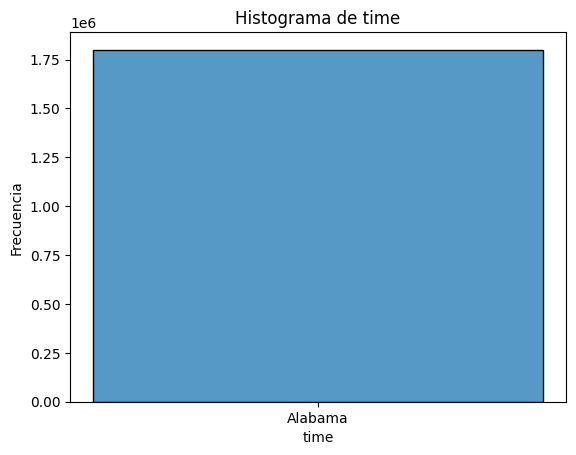

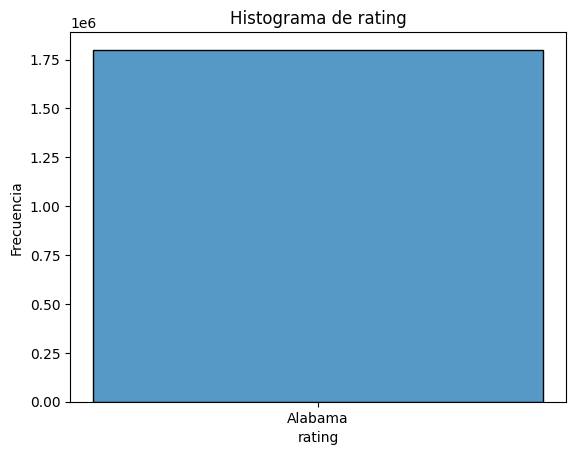


Gráficos de dispersión para pares de columnas numéricas:


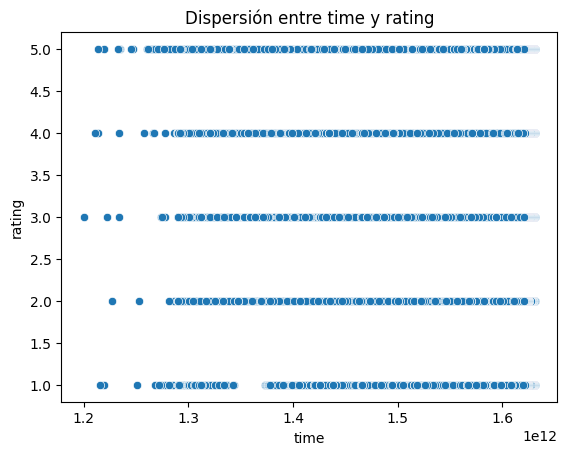


Análisis del archivo: ../data/parquet_files\reviews_Alaska_All.parquet

Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521515 entries, 0 to 521514
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  521515 non-null  object
 1   name     521515 non-null  object
 2   time     521515 non-null  int64 
 3   rating   521515 non-null  int64 
 4   text     298257 non-null  object
 5   pics     20851 non-null   object
 6   resp     44232 non-null   object
 7   gmap_id  521515 non-null  object
 8   state    521515 non-null  object
dtypes: int64(2), object(7)
memory usage: 35.8+ MB

Primeras 5 filas del DataFrame:
| user_id               | name              | time          | rating   | text                                                                                                                                                                                                           

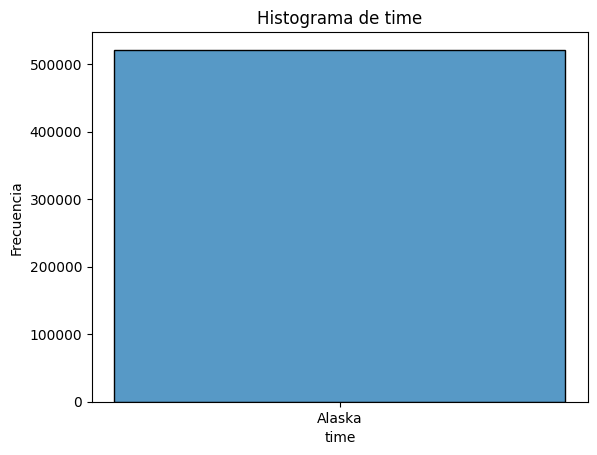

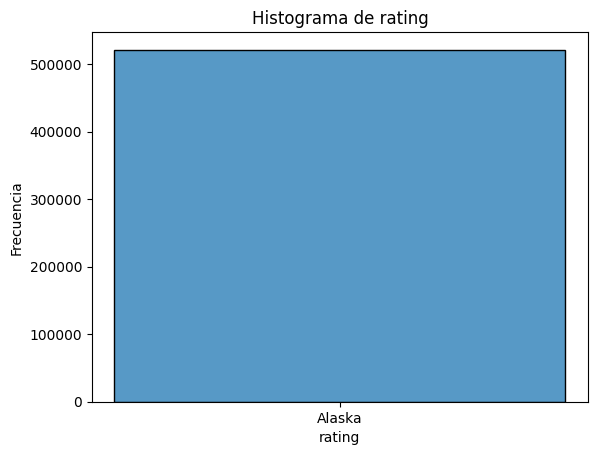


Gráficos de dispersión para pares de columnas numéricas:


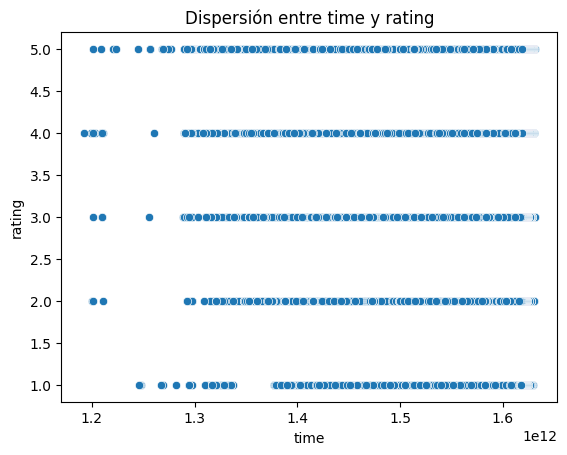


Análisis del archivo: ../data/parquet_files\reviews_Arizona_All.parquet

Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100000 entries, 0 to 2099999
Data columns (total 9 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  object
 1   name     object
 2   time     int64 
 3   rating   int64 
 4   text     object
 5   pics     object
 6   resp     object
 7   gmap_id  object
 8   state    object
dtypes: int64(2), object(7)
memory usage: 144.2+ MB

Primeras 5 filas del DataFrame:
| user_id               | name         | time          | rating   | text                                                                                                                                                                                                                                                                                                                                                                                                       

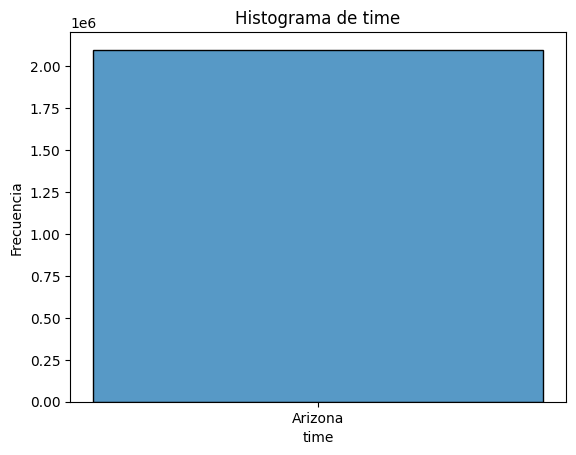

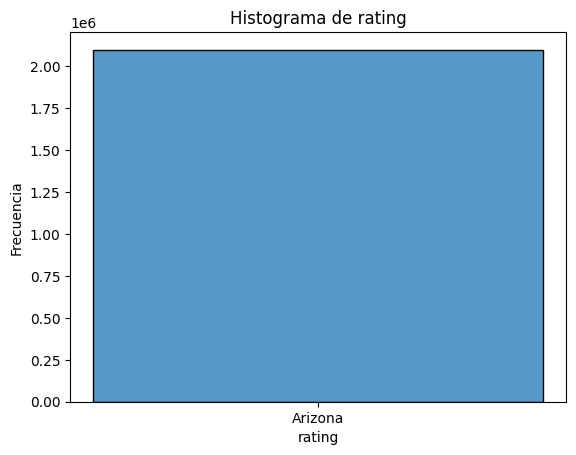


Gráficos de dispersión para pares de columnas numéricas:


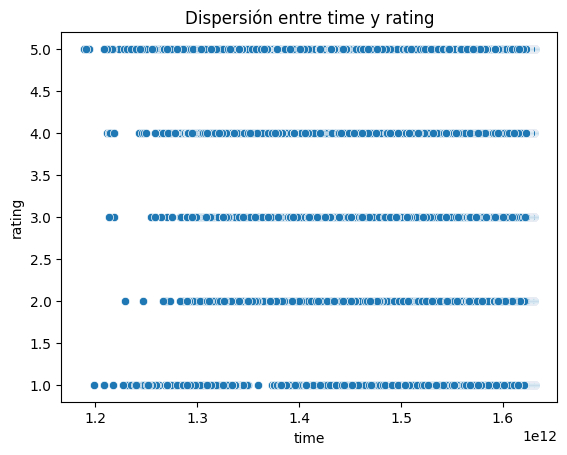

In [2]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

parquet_dir = "../data/parquet_files"

def realizar_eda_parquet(directorio, archivos_seleccionados):
    """
    Realiza un Análisis Exploratorio de Datos (EDA) básico en archivos Parquet.

    Args:
        directorio (str): Directorio que contiene los archivos Parquet.
        archivos_seleccionados (list): Lista de archivos Parquet seleccionados para procesar.
    """
    if not archivos_seleccionados:
        print("No se seleccionaron archivos Parquet para procesar.")
        return

    for archivo in archivos_seleccionados:
        print(f"\nAnálisis del archivo: {archivo}")
        try:
            # Leer el archivo Parquet en un DataFrame de pandas
            df = pd.read_parquet(archivo)

            # Convertir columnas de tipo 'numpy.ndarray' a listas
            for col in df.columns:
                if isinstance(df[col].iloc[0], (list, tuple, dict)): #ya que pd.Series puede contener diccionarios o listas
                    continue
                if isinstance(df[col].iloc[0], type(pd.Series(dtype='object'))):
                    df[col] = df[col].apply(lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(df[col].iloc[0], type(pd.Series(dtype='object'))):
                     df[col] = df[col].apply(lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(df[col].iloc[0], dict):
                     df[col] = df[col].apply(lambda x: {
                        k: (v.tolist() if isinstance(v, pd.Series) else v)
                        for k, v in x.items()
                    } if isinstance(x, dict) else x)
                elif isinstance(df[col].iloc[0], pd.Series):
                    df[col] = df[col].apply(lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(df[col].iloc[0], type(pd.Series(dtype='object'))):
                    df[col] = df[col].apply(lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(df[col].iloc[0], type(pd.Series(dtype='object'))):
                     df[col] = df[col].apply(lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(df[col].iloc[0], dict):
                     df[col] = df[col].apply(lambda x: {
                        k: (v.tolist() if isinstance(v, pd.Series) else v)
                        for k, v in x.items()
                    } if isinstance(x, dict) else x)

            # Mostrar información general del DataFrame
            print("\nInformación general del DataFrame:")
            df.info()

            # Mostrar las primeras filas del DataFrame
            print("\nPrimeras 5 filas del DataFrame:")
            head_df = df.head().copy()
            for col in head_df.columns:
                if isinstance(head_df[col].iloc[0], pd.Series):
                    head_df[col] = head_df[col].apply(
                        lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(head_df[col].iloc[0], dict):
                    head_df[col] = head_df[col].apply(lambda x: {
                        k: (v.tolist() if isinstance(v, pd.Series) else v)
                        for k, v in x.items()
                    } if isinstance(x, dict) else x)
            print(head_df.to_markdown(index=False, numalign="left",
                                            stralign="left"))

            # Mostrar estadísticas descriptivas de las columnas numéricas
            print("\nEstadísticas descriptivas de las columnas numéricas:")
            print(df.describe().to_markdown(numalign="left", stralign="left"))

            # Mostrar el número de valores únicos para columnas no numéricas
            print("\nValores únicos de columnas no numéricas:")
            for columna in df.columns:
                if not pd.api.types.is_numeric_dtype(df[columna]):
                    if isinstance(df[col].iloc[0], pd.Series):
                        num_valores_unicos = df[col].nunique()
                    elif isinstance(df[col].iloc[0], dict):
                        num_valores_unicos = df[col].nunique()
                    else:
                        num_valores_unicos = df[col].nunique()
                    print(f"- {columna}: {num_valores_unicos} valores únicos")

            # Generar gráficos para columnas numéricas
            print("\nGráficos para columnas numéricas:")
            for columna in df.select_dtypes(include=['number']).columns:
                plt.figure()
                plt.title(f"Histograma de {columna}")
                sns.histplot(df[col], kde=False)
                plt.xlabel(columna)
                plt.ylabel("Frecuencia")
                plt.show()

            # Generar gráficos de dispersión para pares de columnas numéricas
            print("\nGráficos de dispersión para pares de columnas numéricas:")
            num_cols = df.select_dtypes(include=['number']).columns
            if len(num_cols) > 1:
                for i in range(len(num_cols)):
                    for j in range(i + 1, len(num_cols)):
                        col1 = num_cols[i]
                        col2 = num_cols[j]
                        plt.figure()
                        plt.title(f"Dispersión entre {col1} y {col2}")
                        sns.scatterplot(data=df, x=col1, y=col2)
                        plt.xlabel(col1)
                        plt.ylabel(col2)
                        plt.show()
            else:
                print(
                    "No hay suficientes columnas numéricas para generar gráficos de dispersión.")

        except Exception as e:
            print(f"Error al procesar el archivo {archivo}: {e}")



def seleccionar_archivos(directorio, extension):
    """
    Permite al usuario seleccionar qué archivos procesar dentro de un directorio.

    Args:
        directorio (str): El directorio que contiene los archivos.
        extension (str): La extensión de los archivos a listar ('.parquet').

    Returns:
        list: Una lista de las rutas completas de los archivos seleccionados.
    """
    archivos = glob.glob(os.path.join(directorio, f"*{extension}"))
    if not archivos:
        print(f"No se encontraron archivos {extension} en {directorio}")
        return []

    print(f"Se encontraron {len(archivos)} archivos {extension} en {directorio}:")
    for i, archivo in enumerate(archivos):
        print(f"{i + 1}. {os.path.basename(archivo)}")

    seleccion = input(
        f"Ingrese los números de los archivos a procesar (separados por coma, 0 para todos, rango ej: 1- {len(archivos)}): ")

    if seleccion == "0":
        return archivos
    else:
        archivos_seleccionados = []
        for s in seleccion.split(","):
            s = s.strip()
            if '-' in s:
                try:
                    inicio, fin = map(int, s.split('-'))
                    if 1 <= inicio <= fin <= len(archivos):
                        archivos_seleccionados.extend(archivos[inicio - 1:fin])
                    else:
                        print(f"Rango inválido: {s}.  Ignorando.")
                except ValueError:
                    print(f"Rango inválido: {s}. Ignorando.")
            else:
                try:
                    indice = int(s) - 1
                    if 0 <= indice < len(archivos):
                        archivos_seleccionados.append(archivos[indice])
                    else:
                        print(f"Índice inválido: {s}. Ignorando.")
                except ValueError:
                    print(f"Entrada inválida: {s}. Ignorando.")
        return archivos_seleccionados


if __name__ == "__main__":
    # Obtener la lista de archivos Parquet
    archivos_parquet = glob.glob(os.path.join(parquet_dir, "*.parquet"))

    # Preguntar al usuario qué archivos procesar
    if archivos_parquet:
        archivos_seleccionados = seleccionar_archivos(parquet_dir, ".parquet")
        # Llamar a la función realizar_eda_parquet con los archivos seleccionados
        realizar_eda_parquet(parquet_dir, archivos_seleccionados)
    else:
        print("No se encontraron archivos Parquet para procesar.")


# Exploración de Datos en Archivos Parquet (EDA)

Este script en Python realiza un **Análisis Exploratorio de Datos (EDA)** en archivos Parquet, permitiendo la inspección de información clave antes de su procesamiento.

## 1. **Selección de Archivos a Procesar**
- Se explora el directorio de archivos Parquet (`parquet_dir`).
- Se permite al usuario seleccionar archivos mediante `input()`, con opción de procesar:
  - Todos los archivos (`0`).
  - Un rango específico (`ej: 1-5`).
  - Archivos individuales (`ej: 2, 4`).

## 2. **Carga de Archivos y Conversión de Tipos**
- Se usa `pd.read_parquet()` para leer cada archivo seleccionado.
- Se convierte contenido de listas o estructuras anidadas (`numpy.ndarray`) en formatos más manejables (`list` o `dict`).

## 3. **Exploración de Datos**
- Se presenta un resumen del DataFrame (`df.info()`).
- Se muestran las primeras filas (`df.head().to_markdown()`) en formato legible.
- Se generan estadísticas descriptivas (`df.describe().to_markdown()`).
- Se identifican valores únicos en columnas no numéricas.

## 4. **Visualización de Datos**
- **Histogramas** (`sns.histplot()`) para columnas numéricas.
- **Gráficos de dispersión** (`sns.scatterplot()`) para pares de características numéricas.
- **Box Plots** (`sns.boxplot()`) para explorar distribución y valores atípicos.

## 5. **Manejo de Errores**
- Se detectan problemas en la lectura y conversión de datos.
- Se informa si no hay suficientes columnas numéricas para análisis avanzados.
- Se previene el procesamiento de archivos vacíos.

## 6. **Aplicaciones del Script**
- Útil para **validar calidad y estructura** de los datos almacenados en Parquet.
- Facilita **detección de sesgos y valores atípicos** antes del análisis.
- Optimiza la **visualización de tendencias** en conjuntos de datos grandes.

Este proceso garantiza un **Análisis Exploratorio Estructurado**, permitiendo la toma de decisiones más informada antes de aplicar transformaciones o modelos sobre los datos.

Se encontraron 53 archivos .parquet en ../data/parquet_files:
1. metadata_sitios_All.parquet
2. places_5Estados.parquet
3. reviews_Alabama_All.parquet
4. reviews_Alaska_All.parquet
5. reviews_Arizona_All.parquet
6. reviews_Arkansas_All.parquet
7. reviews_California_All.parquet
8. reviews_Colorado_All.parquet
9. reviews_Connecticut_All.parquet
10. reviews_Delaware_All.parquet
11. reviews_District_of_Columbia_All.parquet
12. reviews_Florida_All.parquet
13. reviews_Georgia_All.parquet
14. reviews_Hawaii_All.parquet
15. reviews_Idaho_All.parquet
16. reviews_Illinois_All.parquet
17. reviews_Indiana_All.parquet
18. reviews_Iowa_All.parquet
19. reviews_Kansas_All.parquet
20. reviews_Kentucky_All.parquet
21. reviews_Louisiana_All.parquet
22. reviews_Maine_All.parquet
23. reviews_Maryland_All.parquet
24. reviews_Massachusetts_All.parquet
25. reviews_Michigan_All.parquet
26. reviews_Minnesota_All.parquet
27. reviews_Mississippi_All.parquet
28. reviews_Missouri_All.parquet
29. reviews_Montana_All

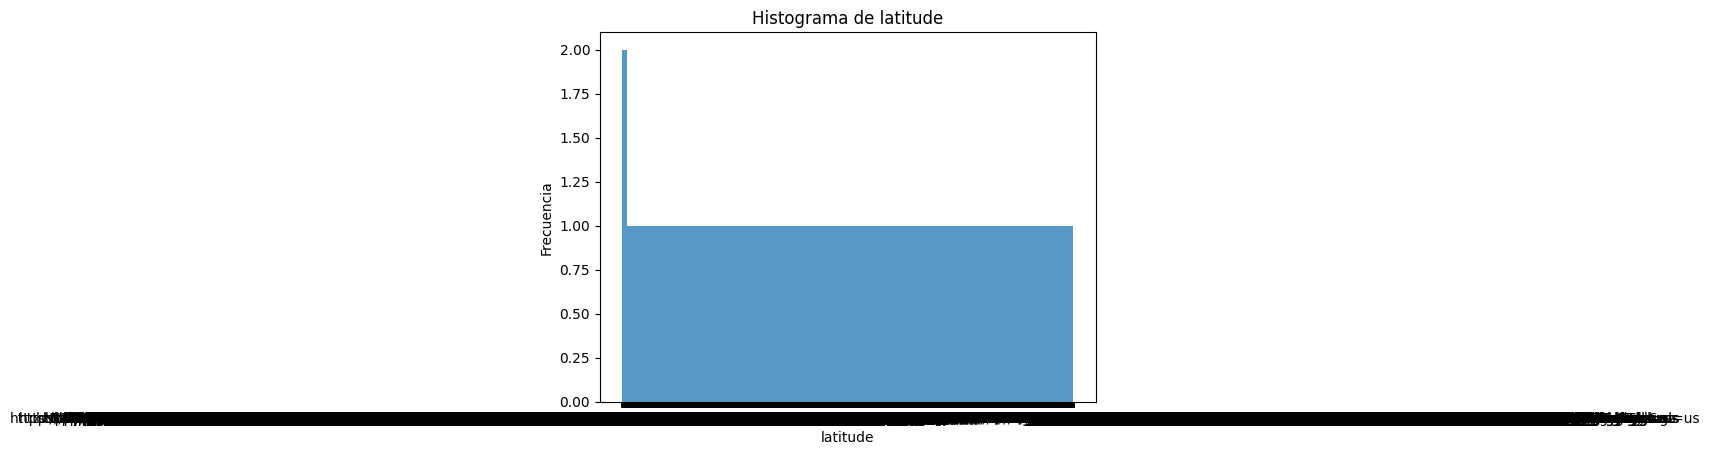

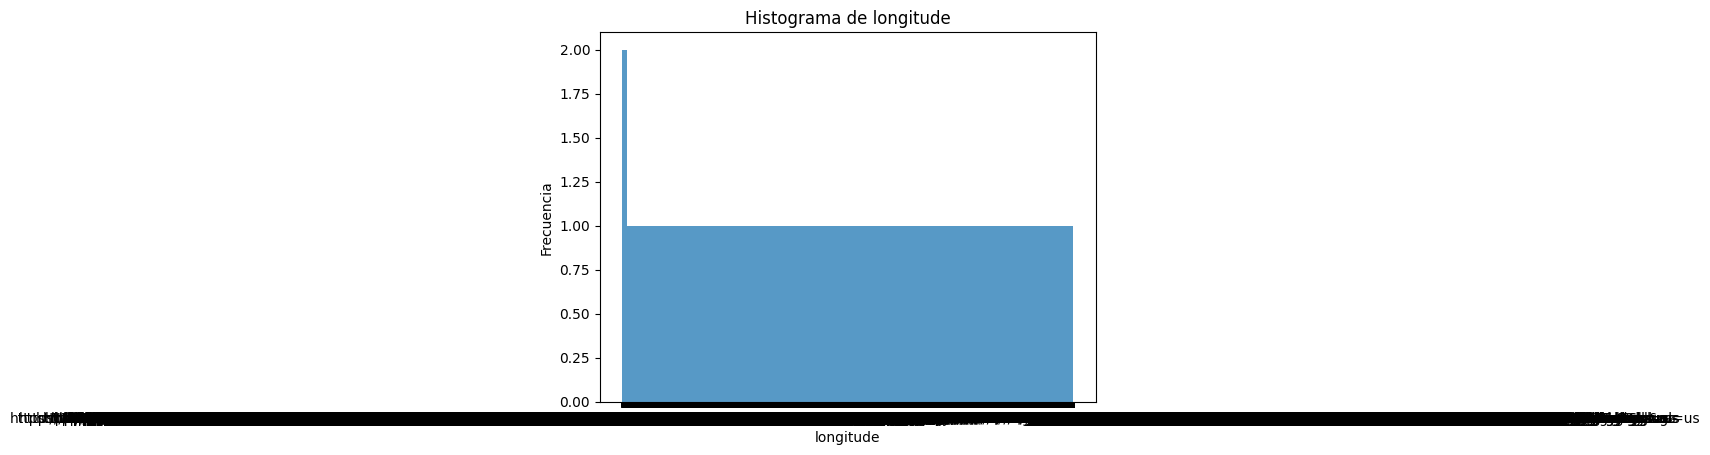

In [ ]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Importa la biblioteca NumPy

parquet_dir = "../data/parquet_files"

def realizar_eda_parquet(directorio, archivos_seleccionados):
    """
    Realiza un Análisis Exploratorio de Datos (EDA) básico en archivos Parquet.

    Args:
        directorio (str): Directorio que contiene los archivos Parquet.
        archivos_seleccionados (list): Lista de archivos Parquet seleccionados para procesar.
    """
    if not archivos_seleccionados:
        print("No se seleccionaron archivos Parquet para procesar.")
        return

    for archivo in archivos_seleccionados:
        print(f"\nAnálisis del archivo: {archivo}")
        try:
            # Leer el archivo Parquet en un DataFrame de pandas
            df = pd.read_parquet(archivo)

            # Convertir columnas de tipo 'numpy.ndarray' a listas
            for col in df.columns:
                if isinstance(df[col].iloc[0], (list, tuple, dict)):  # ya que pd.Series puede contener diccionarios o listas
                    continue
                if isinstance(df[col].iloc[0], type(pd.Series(dtype='object'))):
                    df[col] = df[col].apply(lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(df[col].iloc[0], type(pd.Series(dtype='object'))):
                    df[col] = df[col].apply(lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(df[col].iloc[0], dict):
                    df[col] = df[col].apply(lambda x: {
                        k: (v.tolist() if isinstance(v, pd.Series) else v)
                        for k, v in x.items()
                    } if isinstance(x, dict) else x)
                elif isinstance(df[col].iloc[0], pd.Series):
                    df[col] = df[col].apply(lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(df[col].iloc[0], type(pd.Series(dtype='object'))):
                    df[col] = df[col].apply(lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(df[col].iloc[0], type(pd.Series(dtype='object'))):
                    df[col] = df[col].apply(lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(df[col].iloc[0], dict):
                    df[col] = df[col].apply(lambda x: {
                        k: (v.tolist() if isinstance(v, pd.Series) else v)
                        for k, v in x.items()
                    } if isinstance(x, dict) else x)

            # Mostrar información general del DataFrame
            print("\nInformación general del DataFrame:")
            df.info()

            # Mostrar las primeras filas del DataFrame
            print("\nPrimeras 5 filas del DataFrame:")
            head_df = df.head().copy()
            for col in head_df.columns:
                if isinstance(head_df[col].iloc[0], pd.Series):
                    head_df[col] = head_df[col].apply(
                        lambda x: x.tolist() if isinstance(x, pd.Series) else x)
                elif isinstance(head_df[col].iloc[0], dict):
                    head_df[col] = head_df[col].apply(lambda x: {
                        k: (v.tolist() if isinstance(v, pd.Series) else v)
                        for k, v in x.items()
                    } if isinstance(x, dict) else x)
            print(head_df.to_markdown(index=False, numalign="left",
                                            stralign="left"))

            # Mostrar estadísticas descriptivas de las columnas numéricas
            print("\nEstadísticas descriptivas de las columnas numéricas:")
            print(df.describe().to_markdown(numalign="left", stralign="left"))

            # Mostrar el número de valores únicos para columnas no numéricas
            print("\nValores únicos de columnas no numéricas:")
            for columna in df.columns:
                if not pd.api.types.is_numeric_dtype(df[columna]):
                    tipo_dato = type(df[col].iloc[0])
                    nombre_tipo = tipo_dato.__name__  # Obtiene el nombre de la clase
                    modulo_tipo = tipo_dato.__module__  # Obtiene el módulo al que pertenece
                    print(f"- {columna}: {nombre_tipo} (módulo: {modulo_tipo}), {df[col].nunique()} valores únicos")

            # Generar gráficos para columnas numéricas
            print("\nGráficos para columnas numéricas:")
            for columna in df.select_dtypes(include=['number']).columns:
                plt.figure()
                plt.title(f"Histograma de {columna}")
                sns.histplot(df[col], kde=False)
                plt.xlabel(columna)
                plt.ylabel("Frecuencia")
                plt.show()

            # Generar gráficos de dispersión para pares de columnas numéricas
            print("\nGráficos de dispersión para pares de columnas numéricas:")
            num_cols = df.select_dtypes(include=['number']).columns
            if len(num_cols) > 1:
                for i in range(len(num_cols)):
                    for j in range(i + 1, len(num_cols)):
                        col1 = num_cols[i]
                        col2 = num_cols[j]
                        plt.figure()
                        plt.title(f"Dispersión entre {col1} y {col2}")
                        sns.scatterplot(data=df, x=col1, y=col2)
                        plt.xlabel(col1)
                        plt.ylabel(col2)
                        plt.show()
            else:
                print(
                    "No hay suficientes columnas numéricas para generar gráficos de dispersión.")

        except Exception as e:
            print(f"Error al procesar el archivo {archivo}: {e}")



def seleccionar_archivos(directorio, extension):
    """
    Permite al usuario seleccionar qué archivos procesar dentro de un directorio.

    Args:
        directorio (str): El directorio que contiene los archivos.
        extension (str): La extensión de los archivos a listar ('.parquet').

    Returns:
        list: Una lista de las rutas completas de los archivos seleccionados.
    """
    archivos = glob.glob(os.path.join(directorio, f"*{extension}"))
    if not archivos:
        print(f"No se encontraron archivos {extension} en {directorio}")
        return []

    print(f"Se encontraron {len(archivos)} archivos {extension} en {directorio}:")
    for i, archivo in enumerate(archivos):
        print(f"{i + 1}. {os.path.basename(archivo)}")

    seleccion = input(
        f"Ingrese los números de los archivos a procesar (separados por coma, 0 para todos, rango ej: 1- {len(archivos)}): ")

    if seleccion == "0":
        return archivos
    else:
        archivos_seleccionados = []
        for s in seleccion.split(","):
            s = s.strip()
            if '-' in s:
                try:
                    inicio, fin = map(int, s.split('-'))
                    if 1 <= inicio <= fin <= len(archivos):
                        archivos_seleccionados.extend(archivos[inicio - 1:fin])
                    else:
                        print(f"Rango inválido: {s}.  Ignorando.")
                except ValueError:
                    print(f"Rango inválido: {s}. Ignorando.")
            else:
                try:
                    indice = int(s) - 1
                    if 0 <= indice < len(archivos):
                        archivos_seleccionados.append(archivos[indice])
                    else:
                        print(f"Índice inválido: {s}. Ignorando.")
                except ValueError:
                    print(f"Entrada inválida: {s}. Ignorando.")
        return archivos_seleccionados


if __name__ == "__main__":
    # Obtener la lista de archivos Parquet
    archivos_parquet = glob.glob(os.path.join(parquet_dir, "*.parquet"))

    # Preguntar al usuario qué archivos procesar
    if archivos_parquet:
        archivos_seleccionados = seleccionar_archivos(parquet_dir, ".parquet")
        # Llamar a la función realizar_eda_parquet con los archivos seleccionados
        realizar_eda_parquet(parquet_dir, archivos_seleccionados)
    else:
        print("No se encontraron archivos Parquet para procesar.")


# Detección de Duplicados y Análisis de Tipos de Datos en Archivos JSON

Este script en Python analiza archivos JSON dentro de un directorio, detectando **duplicados** y clasificando **tipos de datos** presentes en los registros.

## 1. **Identificación de Archivos JSON**
- Se recorre el directorio especificado (`directorio_data`) en busca de archivos JSON.
- Se usa `os.walk()` para recorrer subdirectorios y archivos.
- Se procesan únicamente archivos con extensión `.json`.

## 2. **Procesamiento de Registros JSON**
- Se carga cada línea de los archivos JSON de forma independiente (`json.loads(linea.strip())`).
- Se almacenan registros en un conjunto (`set`) para identificar duplicados.
- Se convierte cada registro en tuplas ordenadas (`datos_tuplas`) para facilitar la comparación.
- Se detectan registros repetidos y se contabilizan.

## 3. **Clasificación de Tipos de Datos**
- Se analiza cada atributo del JSON, determinando su tipo (`type(valor).__name__`).
- Se genera un resumen con los tipos de datos observados por atributo.

## 4. **Manejo de Errores**
- Se capturan y manejan errores de lectura (`FileNotFoundError`).
- Se identifican líneas JSON con problemas de decodificación (`json.JSONDecodeError`).
- Se informan registros problemáticos sin detener la ejecución.

## 5. **Resultados y Aplicaciones**
- Se muestra el número de **registros duplicados** identificados.
- Se imprime un listado de **atributos con sus tipos de datos** detectados.
- Útil para validar la **integridad y consistencia** de los archivos JSON antes de procesarlos.

Este análisis facilita la **depuración de datos**, permitiendo tomar decisiones sobre limpieza y estructura antes de usarlos en modelos o análisis más avanzados.

In [ ]:
import json
import os

def obtener_tipo_dato(valor):
    """ Devuelve el tipo de dato en formato de cadena. """
    return type(valor).__name__

def analizar_json_lineas(archivo_json, conjunto_vistos):
    """ Procesa cada línea del archivo JSON, detectando duplicados y tipos de datos. """
    duplicados = []
    estructura_atributos = {}

    try:
        with open(archivo_json, 'r', encoding='utf-8') as f:
            for linea in f:
                try:
                    datos_json = json.loads(linea.strip())  # Cargar la línea como JSON
                    datos_tuplas = tuple((k, str(v)) for k, v in sorted(datos_json.items()))  # Convertir valores a string

                    # Detectar duplicados
                    if datos_tuplas in conjunto_vistos:
                        duplicados.append(datos_json)
                    else:
                        conjunto_vistos.add(datos_tuplas)
                    
                    # Analizar tipos de datos
                    for clave, valor in datos_json.items():
                        estructura_atributos[clave] = obtener_tipo_dato(valor)

                except json.JSONDecodeError:
                    print(f"Error al decodificar línea en {archivo_json}: {linea.strip()}")

        # Mostrar análisis
        print(f"\nArchivo: {archivo_json}")
        print(f"Registros duplicados encontrados: {len(duplicados)}")
        print("Tipos de datos por atributo:")
        for atributo, tipo in estructura_atributos.items():
            print(f"{atributo}: {tipo}")

    except FileNotFoundError:
        print(f"Error: El archivo {archivo_json} no fue encontrado.")

def analizar_json_en_directorio(ruta_directorio):
    """ Busca archivos JSON en un directorio y los analiza recursivamente. """
    print(f"Analizando archivos JSON en el directorio: {ruta_directorio}")

    if not os.path.isdir(ruta_directorio):
        print(f"Error: El directorio '{ruta_directorio}' no existe.")
        return

    conjunto_vistos = set()  # Conjunto para almacenar registros únicos

    for directorio_actual, _, archivos in os.walk(ruta_directorio):
        for nombre_archivo in archivos:
            if nombre_archivo.endswith(".json"):
                ruta_completa = os.path.join(directorio_actual, nombre_archivo)
                analizar_json_lineas(ruta_completa, conjunto_vistos)

# Especifica la ruta del directorio raíz
directorio_data = "../data"

# Llama a la función para analizar los archivos JSON
analizar_json_en_directorio(directorio_data)

Analizando archivos JSON en el directorio: ../data

Archivo: ../data\google_maps\metadata-sitios\1.json
Registros duplicados encontrados: 26573
Tipos de datos por atributo:
name: str
address: str
gmap_id: str
description: NoneType
latitude: float
longitude: float
category: list
avg_rating: float
num_of_reviews: int
price: NoneType
hours: list
MISC: dict
state: str
relative_results: list
url: str

Archivo: ../data\google_maps\metadata-sitios\10.json
Registros duplicados encontrados: 1
Tipos de datos por atributo:
name: str
address: str
gmap_id: str
description: NoneType
latitude: float
longitude: float
category: list
avg_rating: int
num_of_reviews: int
price: NoneType
hours: list
MISC: dict
state: str
relative_results: list
url: str

Archivo: ../data\google_maps\metadata-sitios\11.json
Registros duplicados encontrados: 1
Tipos de datos por atributo:
name: str
address: str
gmap_id: str
description: NoneType
latitude: float
longitude: float
category: list
avg_rating: int
num_of_reviews: i

Metadata

# Generación de Diccionario de Datos a partir de Archivos JSON

Este script en Python analiza archivos JSON dentro de un directorio, recopilando estadísticas sobre los atributos y tipos de datos presentes, generando un **diccionario de datos** en formato tabular.

## 1. **Exploración Recursiva de Archivos JSON**
- Se recorre el directorio especificado (`directorio_data`) en busca de archivos JSON.
- Se usa `os.walk()` para recorrer subdirectorios y detectar archivos `.json`.

## 2. **Procesamiento de Registros JSON**
- Se carga cada línea de los archivos JSON para analizar su contenido (`json.loads(linea.strip())`).
- Se maneja la presencia de caracteres especiales como **BOM (Byte Order Mark)** en UTF-8.
- Se contabilizan los atributos y su frecuencia de aparición en los registros.

## 3. **Clasificación de Tipos de Datos**
- Se identifica el tipo de cada atributo (`type(valor).__name__`).
- Se genera una estructura `feature_stats` que almacena:
  - **Tipos de datos observados** en cada atributo.
  - **Número de valores no nulos** por atributo.

## 4. **Generación del Diccionario de Datos**
- Se calcula el número total de registros en el archivo.
- Se derivan conteos de **valores nulos** (diferencia entre registros totales y valores no nulos).
- Se ordenan los atributos alfabéticamente y se presentan en **formato tabular** (`df_summary.to_markdown()`).

## 5. **Manejo de Errores**
- Se captura y maneja errores en la lectura de archivos (`FileNotFoundError`).
- Se ignoran líneas JSON inválidas sin detener la ejecución.
- Se informa si un archivo no contiene registros procesables.

## 6. **Aplicaciones del Script**
- Útil para **validar estructura y calidad** de archivos JSON antes de análisis.
- Facilita la **generación de documentación** sobre la estructura de datos.
- Detecta **problemas de formato y presencia de valores nulos** en los registros.

Este análisis permite estructurar los datos de forma clara, asegurando su calidad antes de ser utilizados en procesos analíticos o integración con bases de datos.

In [ ]:
import json
import os
import pandas as pd
from collections import defaultdict
import sys

# Puedes aumentar el límite de recursión si tus objetos JSON son extremadamente anidados,
# pero úsalo con precaución ya que puede causar StackOverflowError.
# sys.setrecursionlimit(2000)

def analyze_json_line(line_json, feature_stats):
    """
    Analiza una sola línea JSON para recopilar tipos de datos y recuentos no nulos por característica.

    Args:
        line_json (str): Una sola línea que se espera sea una cadena de objeto JSON.
        feature_stats (defaultdict): Un diccionario para acumular estadísticas {feature: {'types': set(), 'non_null_count': int}}.
    """
    try:
        # Manejar posible BOM (Byte Order Mark) si está presente (común en UTF-8 con algunos editores)
        if line_json.startswith('\ufeff'):
            line_json = line_json[1:]

        data = json.loads(line_json)
        if isinstance(data, dict):
            for key, value in data.items():
                # Asegurarse de que la clave existe en feature_stats
                if key not in feature_stats:
                    feature_stats[key] = {'types': set(), 'non_null_count': 0}

                # Registrar el tipo de dato si no es nulo e incrementar el recuento no nulo
                if value is not None:
                    # Obtener el nombre del tipo base para tipos comunes, manejar otros tal cual
                    value_type = type(value)
                    if isinstance(value, (int, float, str, bool, list, dict)):
                         type_name = type(value).__name__
                    elif value_type.__name__ == 'NoneType': # Verificación explícita aunque manejada por 'is not None'
                         type_name = 'None'
                    else:
                         type_name = str(value_type) # Retorno para tipos menos comunes

                    feature_stats[key]['types'].add(type_name)
                    feature_stats[key]['non_null_count'] += 1
                # Si el valor es None, no añadimos tipo, non_null_count permanece igual.
                # El recuento de nulos se calculará más tarde (líneas totales - recuento no nulo)

    except json.JSONDecodeError as e:
        # Manejar líneas que no son JSON válido
        # print(f"Saltando línea JSON inválida debido a error de decodificación: {e} - Línea: {line_json.strip()[:100]}...") # Opcional: para depuración
        pass # Saltar líneas inválidas
    except Exception as e:
        # Capturar otros posibles errores durante el procesamiento de la línea
        # print(f"Saltando línea debido a error inesperado: {e} - Línea: {line_json.strip()[:100]}...") # Opcional: para depuración
        pass


def analyze_json_file(file_path):
    """
    Analiza un archivo JSON Lines para generar un resumen de diccionario de datos.

    Args:
        file_path (str): La ruta al archivo JSON Lines.

    Returns:
        tuple: Una tupla que contiene (feature_stats, total_lines, file_name)
               o None si el archivo no puede ser procesado.
    """
    feature_stats = defaultdict(lambda: {'types': set(), 'non_null_count': 0})
    total_lines = 0
    file_name = os.path.basename(file_path)

    try:
        # Usar codificación 'utf-8', se puede añadir manejo de errores como errors='ignore' o errors='replace'
        # si sospechas problemas de codificación, pero utf-8 es estándar para JSON.
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                total_lines += 1
                analyze_json_line(line, feature_stats)

        return dict(feature_stats), total_lines, file_name # Convertir defaultdict a dict para el retorno

    except FileNotFoundError:
        print(f"Error: El archivo {file_path} no fue encontrado.")
        return None
    except Exception as e:
        print(f"Ocurrió un error al procesar {file_path}: {e}")
        return None

def generate_data_dictionary_for_directory(ruta_directorio):
    """
    Analiza todos los archivos JSON Lines en un directorio y sus subdirectorios
    e imprime un resumen de diccionario de datos para cada archivo en formato de tabla.

    Args:
        ruta_directorio (str): El directorio raíz a escanear.
    """
    print(f"Generando diccionarios de datos para archivos JSON recursivamente en: {ruta_directorio}")

    if not os.path.isdir(ruta_directorio):
        print(f"Error: El directorio '{ruta_directorio}' no existe.")
        return

    processed_files_count = 0

    for directorio_actual, subdirectorios, archivos in os.walk(ruta_directorio):
        # Opcional: puedes modificar subdirectorios aquí si quieres saltar algunos directorios
        # Ejemplo: subdirectorios[:] = [d for d in subdirectorios if not d.startswith('.')]

        for nombre_archivo in archivos:
            if nombre_archivo.lower().endswith(".json"): # Verificación sin distinguir mayúsculas/minúsculas
                ruta_completa = os.path.join(directorio_actual, nombre_archivo)
                print(f"\n--- Procesando Archivo: {ruta_completa} ---")
                file_analysis_result = analyze_json_file(ruta_completa)

                if file_analysis_result:
                    feature_stats, total_lines, file_name = file_analysis_result
                    processed_files_count += 1

                    if total_lines == 0:
                        print(f"Archivo {file_name} está vacío o solo contiene líneas inválidas.")
                        print("-" * 50)
                        continue

                    # Preparar datos para la tabla
                    table_data = []
                    # Ordenar las características alfabéticamente para una salida de tabla consistente
                    sorted_features = sorted(feature_stats.keys())

                    for feature in sorted_features:
                        stats = feature_stats[feature]
                        # Ordenar los tipos alfabéticamente para una salida consistente
                        observed_types = ", ".join(sorted(list(stats['types'])))
                        non_null_count = stats['non_null_count']
                        null_count = total_lines - non_null_count

                        table_data.append({
                            'Feature': feature,
                            'Data Types Observed': observed_types,
                            'Total Records': total_lines,
                            'Non-Null Count': non_null_count,
                            'Null Count': null_count
                        })

                    # Crear e imprimir la tabla DataFrame
                    if table_data: # Solo crear DataFrame si hay datos
                        df_summary = pd.DataFrame(table_data)

                        print(f"\nResumen del Diccionario de Datos para {file_name}:")
                        # Usar .to_markdown() que es adecuado para salida de texto
                        # Asegurarse de tener la librería 'tabulate' instalada para to_markdown
                        # pip install tabulate
                        print(df_summary.to_markdown(index=False))
                        print("-" * 50)
                    else:
                         print(f"No se encontraron características válidas en {file_name} después de procesar.")
                         print("-" * 50)


    if processed_files_count == 0:
        print("\nNo se encontraron archivos .json en el directorio especificado y sus subdirectorios.")


# Especifica la ruta del directorio raíz
# Asegúrate de que '../data' sea la ruta correcta a tu carpeta de datos
directorio_data = "../data"

# Llama a la función para generar diccionarios de datos
generate_data_dictionary_for_directory(directorio_data)

# Sumarización de Diccionarios de Datos por Directorio en Archivos JSON

Este script en Python analiza archivos JSON dentro de un directorio, identificando **tipos de datos**, **conteo de valores no nulos** y **detección de registros inválidos**, generando un **resumen estructurado por directorio**.

## 1. **Exploración Recursiva de Archivos JSON**
- Se recorre el directorio raíz (`directorio_data`) en busca de archivos JSON en subdirectorios.
- Se usa `os.walk()` para encontrar archivos `.json` sin diferenciar mayúsculas/minúsculas.

## 2. **Procesamiento de Registros JSON**
- Se carga cada línea de los archivos JSON (`json.loads(linea.strip())`).
- Se maneja correctamente la presencia de **BOM (Byte Order Mark)** en UTF-8.
- Se recopilan estadísticas sobre **tipos de datos** y **valores no nulos**.

## 3. **Sumarización de Datos por Directorio**
- Se consolidan datos de todos los archivos dentro de cada directorio.
- Se almacena un resumen de estadísticas en `directory_feature_stats`.
- Se contabilizan **valores nulos** por comparación con el número total de registros.

## 4. **Generación de Diccionario de Datos**
- Se organiza la información en un **DataFrame** tabular (`df_summary.to_markdown()`).
- Se presentan métricas clave:
  - **Tipos de datos observados** en cada atributo.
  - **Conteo de valores no nulos** y **valores nulos**.
  - **Total de registros procesados** por directorio.

## 5. **Manejo de Errores**
- Se capturan errores de lectura (`FileNotFoundError`) para evitar interrupciones.
- Se identifican archivos sin registros válidos y se omiten en la salida.
- Se informa sobre directorios sin archivos JSON procesables.

## 6. **Aplicaciones del Script**
- Útil para **auditoría de datos**, asegurando consistencia en múltiples archivos JSON.
- Facilita la **detección de problemas de formato y calidad** en registros JSON.
- Permite una **validación rápida** antes de realizar transformaciones o análisis más avanzados.

Este proceso mejora la estructuración y comprensión de los datos antes de integrarlos en modelos o bases de datos.

In [ ]:
import json
import os
import pandas as pd
from collections import defaultdict
import sys

# Puedes aumentar el límite de recursión si tus objetos JSON son extremadamente anidados,
# pero úsalo con precaución ya que puede causar StackOverflowError.
# sys.setrecursionlimit(2000)

# --- Reutilizamos la función analyze_json_line del script anterior ---
def analyze_json_line(line_json, feature_stats):
    """
    Analiza una sola línea JSON para recopilar tipos de datos y recuentos no nulos por característica.

    Args:
        line_json (str): Una sola línea que se espera sea una cadena de objeto JSON.
        feature_stats (defaultdict): Un diccionario para acumular estadísticas {feature: {'types': set(), 'non_null_count': int}}.
    """
    try:
        # Manejar posible BOM (Byte Order Mark) si está presente (común en UTF-8 con algunos editores)
        if line_json.startswith('\ufeff'):
            line_json = line_json[1:]

        data = json.loads(line_json)
        if isinstance(data, dict):
            for key, value in data.items():
                # Asegurarse de que la clave existe en feature_stats
                if key not in feature_stats:
                    feature_stats[key] = {'types': set(), 'non_null_count': 0}

                # Registrar el tipo de dato si no es nulo e incrementar el recuento no nulo
                if value is not None:
                    # Obtener el nombre del tipo base para tipos comunes, manejar otros tal cual
                    value_type = type(value)
                    if isinstance(value, (int, float, str, bool, list, dict)):
                         type_name = type(value).__name__
                    elif value_type.__name__ == 'NoneType': # Verificación explícita aunque manejada por 'is not None'
                         type_name = 'None'
                    else:
                         type_name = str(value_type) # Retorno para tipos menos comunes

                    feature_stats[key]['types'].add(type_name)
                    feature_stats[key]['non_null_count'] += 1
                # Si el valor es None, no añadimos tipo, non_null_count permanece igual.
                # El recuento de nulos se calculará más tarde (líneas totales - recuento no nulo)

    except json.JSONDecodeError as e:
        # Manejar líneas que no son JSON válido
        # print(f"Saltando línea JSON inválida debido a error de decodificación: {e} - Línea: {line_json.strip()[:100]}...") # Opcional: para depuración
        pass # Saltar líneas inválidas
    except Exception as e:
        # Capturar otros posibles errores durante el procesamiento de la línea
        # print(f"Saltando línea debido a error inesperado: {e} - Línea: {line_json.strip()[:100]}...") # Opcional: para depuración
        pass

# --- Nueva función para analizar un archivo y actualizar estadísticas del directorio ---
def analyze_json_file_for_summary(file_path, directory_feature_stats):
    """
    Analiza un solo archivo JSON Lines y añade sus estadísticas a las estadísticas acumuladas del directorio.

    Args:
        file_path (str): La ruta al archivo JSON Lines.
        directory_feature_stats (defaultdict): Un diccionario que acumula estadísticas
                                               {feature: {'types': set(), 'non_null_count': int}} para el directorio.

    Returns:
        int: El número total de líneas procesadas en este archivo, o 0 si hay un error.
    """
    file_total_lines = 0
    try:
        # Usar codificación 'utf-8', se puede añadir manejo de errores como errors='ignore' o errors='replace'
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                file_total_lines += 1
                # Analizar la línea y actualizar las estadísticas del directorio directamente
                analyze_json_line(line, directory_feature_stats)

    except FileNotFoundError:
        print(f"Error: El archivo {file_path} no fue encontrado. Saltando.")
        return 0 # Retornar 0 líneas procesadas para este archivo
    except Exception as e:
        print(f"Ocurrió un error al procesar {file_path}: {e}. Saltando.")
        return 0 # Retornar 0 líneas procesadas para este archivo

    return file_total_lines

# --- Función principal modificada para sumarizar por directorio ---
def summarize_data_dictionary_by_directory(ruta_directorio):
    """
    Analiza todos los archivos JSON Lines en un directorio y sus subdirectorios,
    sumariza estadísticas por directorio, e imprime un resumen de diccionario de datos
    para cada directorio en formato de tabla.

    Args:
        ruta_directorio (str): El directorio raíz a escanear.
    """
    print(f"Sumarizando diccionarios de datos por directorio para archivos JSON recursivamente en: {ruta_directorio}")

    if not os.path.isdir(ruta_directorio):
        print(f"Error: El directorio '{ruta_directorio}' no existe.")
        return

    # dictionary to store {directory_path: {'feature_stats': {}, 'total_records': int}}
    directory_summaries = {}

    # Usar os.walk para visitar cada directorio
    for directorio_actual, subdirectorios, archivos in os.walk(ruta_directorio):
        print(f"\n--- Entrando en Directorio: {directorio_actual} ---")

        # Inicializar estadísticas y contador para el directorio actual
        current_directory_stats = defaultdict(lambda: {'types': set(), 'non_null_count': 0})
        current_directory_total_lines = 0

        # Filtrar solo archivos JSON en el directorio actual
        json_files_in_dir = [f for f in archivos if f.lower().endswith(".json")]

        if not json_files_in_dir:
            print("No se encontraron archivos .json en este directorio.")
            # No guardamos ni imprimimos resumen si no hay archivos JSON o son inválidos
            continue

        # Procesar cada archivo JSON en el directorio actual
        for nombre_archivo in json_files_in_dir:
            ruta_completa = os.path.join(directorio_actual, nombre_archivo)
            print(f"  Procesando archivo para resumen: {nombre_archivo}")
            # Analizar el archivo y acumular estadísticas en current_directory_stats
            lines_in_file = analyze_json_file_for_summary(ruta_completa, current_directory_stats)
            # Sumar las líneas de este archivo al total del directorio
            current_directory_total_lines += lines_in_file

        # --- Generar la tabla de resumen después de procesar todos los archivos en el directorio ---
        if current_directory_total_lines > 0:
            # Preparar las estadísticas finales para este directorio
            final_feature_stats = {}
            for feature, stats in current_directory_stats.items():
                 # Convertir el conjunto de tipos a una cadena ordenada
                 final_feature_stats[feature] = {
                     'types': ", ".join(sorted(list(stats['types']))),
                     'non_null_count': stats['non_null_count']
                 }

            # Opcional: Guardar el resumen del directorio si necesitas procesarlo más tarde
            # directory_summaries[directorio_actual] = {
            #     'feature_stats': final_feature_stats,
            #     'total_records': current_directory_total_lines
            # }

            # Preparar datos para la tabla para este directorio
            table_data = []
            # Ordenar las características alfabéticamente para una salida de tabla consistente
            sorted_features = sorted(final_feature_stats.keys())

            for feature in sorted_features:
                 stats = final_feature_stats[feature]
                 non_null_count = stats['non_null_count']
                 # Calcular nulos basado en el total de líneas del directorio
                 null_count = current_directory_total_lines - non_null_count

                 table_data.append({
                     'Feature': feature,
                     'Data Types Observed (across files)': stats['types'], # Usar cadena ya formateada
                     'Total Records (in dir)': current_directory_total_lines,
                     'Non-Null Count (in dir)': non_null_count,
                     'Null Count (in dir)': null_count
                 })

            # Crear e imprimir la tabla DataFrame para este directorio
            if table_data: # Solo crear DataFrame si hay datos de características
                 df_summary = pd.DataFrame(table_data)
                 print(f"\n--- Resumen del Diccionario de Datos para Directorio: {directorio_actual} ---")
                 # Asegurarse de que la librería 'tabulate' esté instalada para to_markdown
                 # pip install tabulate
                 print(df_summary.to_markdown(index=False))
                 print("-" * 80) # Separador más largo para resumen de directorio
            else:
                 print(f"No se encontraron características válidas en los archivos JSON en {directorio_actual}.")
                 print("-" * 80)
        else:
            # Este caso ocurre si se encontraron archivos pero todas las líneas fueron JSON inválido
            print(f"No se procesaron líneas JSON válidas en los archivos en {directorio_actual}.")
            print("-" * 80)


    # Opcional: Puedes añadir aquí código para procesar 'directory_summaries' si lo almacenaste.
    # Por ahora, simplemente imprimimos los resultados del recorrido.
    print("\n--- Proceso de Sumarización por Directorio Completo ---")


# Especifica la ruta del directorio raíz
# Asegúrate de que '../data' sea la ruta correcta a tu carpeta de datos
directorio_data = "../data"

# Llama a la función para generar diccionarios de datos sumarizados
summarize_data_dictionary_by_directory(directorio_data)

# Consolidación de Archivos JSON de Reseñas por Estado

Este script en Python procesa múltiples archivos JSON en una estructura de directorios, consolidando reseñas por estado en un único archivo CSV.

## 1. **Exploración de Archivos JSON**
- Se define `directorio_base` como la ubicación raíz donde se encuentran las reseñas organizadas por estado.
- Se recorren los subdirectorios para identificar archivos JSON dentro de cada estado.

## 2. **Carga y Validación de Datos**
- Se verifica que los archivos JSON contienen datos válidos (`contenido.strip()`).
- Se maneja el formato **JSON-Lines (NDJSON)** leyendo cada línea como un objeto JSON independiente.
- Se captura y gestiona errores de decodificación (`json.JSONDecodeError`).

## 3. **Conversión a DataFrame**
- Se convierte cada conjunto de reseñas en un `Pandas.DataFrame`.
- Se agrega la columna `"estado"` para identificar el origen de cada registro.
- Se acumulan los `DataFrames` en una lista para su posterior consolidación.

## 4. **Unión y Exportación de Datos**
- Se concatenan todos los `DataFrames` en uno solo (`pd.concat()`).
- Se imprime un resumen del conjunto de datos consolidado (`df_final.info()` y `df_final.head()`).
- Se exporta el resultado a un archivo CSV (`df_final.to_csv("reviews_estados_mashup.csv")`).

## 5. **Manejo de Errores**
- Se informa sobre archivos vacíos o con estructuras inesperadas.
- Se previenen interrupciones por excepciones en la lectura de archivos JSON.

## 6. **Aplicaciones del Script**
- Permite consolidar **reseñas por estado** en un único dataset para análisis.
- Facilita la detección de **inconsistencias y formatos irregulares** en los datos.
- Optimiza la estructura antes de aplicar métodos analíticos o de visualización.

Este script es esencial para gestionar y limpiar datos de reseñas almacenadas en múltiples archivos JSON antes de utilizarlas en análisis más complejos.

In [ ]:
import os
import json
import pandas as pd

# Definir el directorio base
directorio_base = "../data/google_maps/reviews-estados"

# Lista para almacenar los DataFrames de cada estado
dataframes = []

# Recorrer subdirectorios (cada estado)
for estado in os.listdir(directorio_base):
    ruta_estado = os.path.join(directorio_base, estado)

    # Verificar si es un directorio
    if os.path.isdir(ruta_estado):
        print(f"Procesando estado: {estado}")

        for archivo_json in os.listdir(ruta_estado):
            ruta_json = os.path.join(ruta_estado, archivo_json)

            if archivo_json.endswith(".json"):
                try:
                    with open(ruta_json, "r", encoding="utf-8") as f:
                        contenido = f.read().strip()

                        if not contenido:
                            print(f"Archivo vacío: {archivo_json}. Saltando.")
                            continue

                        # Manejo de JSON-Lines (NDJSON)
                        datos = []
                        with open(ruta_json, "r", encoding="utf-8") as f_json:
                            for linea in f_json:
                                try:
                                    datos.append(json.loads(linea.strip()))
                                except json.JSONDecodeError as e:
                                    print(f"Error en línea de {archivo_json}: {e}. Saltando.")

                        if datos:
                            df = pd.DataFrame(datos)
                            df["estado"] = estado
                            dataframes.append(df)
                        else:
                            print(f"Estructura inesperada en {archivo_json}, saltando.")

                except Exception as e:
                    print(f"Error inesperado en {archivo_json}: {e}. Saltando.")

# Unir todos los DataFrames en uno solo
if dataframes:
    df_final = pd.concat(dataframes, ignore_index=True)
    print("\nResumen de datos combinados:")
    print(df_final.info())
    print(df_final.head())

    df_final.to_csv("reviews_estados_mashup.csv", index=False)
    print("Archivo guardado: reviews_estados_mashup.csv")
else:
    print("No se encontraron datos válidos para unir.")

# Consolidación y Análisis de Archivos Parquet

Este script en Python procesa múltiples archivos **Parquet**, recopilando estadísticas clave sobre las características y su calidad dentro del conjunto de datos.

## 1. **Exploración de Archivos Parquet**
- Se define `directorio_parquet` como la ubicación donde se almacenan los archivos.
- Se identifican archivos con el prefijo `reviews_` y extensión `.parquet`.
- Se recorren todos los archivos para analizar su contenido.

## 2. **Carga y Análisis de Datos**
- Cada archivo Parquet se carga en un `Pandas.DataFrame`.
- Se mantiene un diccionario `feature_stats` para recopilar estadísticas por característica:
  - **Tipos de datos observados** (`dtype`).
  - **Número de valores no nulos** (`count()`).
  - **Total de registros** en todos los archivos combinados.

## 3. **Generación de Tabla de Resumen**
- Se consolidan las métricas en un `DataFrame` de resumen:
  - **Feature**: Nombre de la característica.
  - **Tipos de datos observados**: Conjunto de tipos encontrados en distintos archivos.
  - **Total de registros**: Conteo global en todos los archivos procesados.
  - **Conteo de valores no nulos** y **nulos** por característica.

## 4. **Presentación y Exportación de Resultados**
- Se muestra el resumen en formato tabular (`df_resumen.to_markdown()`).
- Se guarda la tabla consolidada en un archivo **CSV** (`reviews_consolidado_summary.csv`).

## 5. **Manejo de Errores**
- Se captura cualquier problema en la lectura de archivos (`Exception`).
- Se informa si un archivo Parquet no puede ser procesado correctamente.

## 6. **Aplicaciones del Script**
- Útil para realizar **auditoría de calidad** de archivos Parquet.
- Facilita la identificación de **problemas de consistencia** en tipos de datos y valores nulos.
- Optimiza la revisión de múltiples conjuntos de datos antes de integrarlos en análisis más profundos.

Este proceso proporciona una visión estructurada del contenido de archivos Parquet, asegurando una adecuada exploración y validación de los datos.

In [ ]:
import os
import pandas as pd
from collections import defaultdict

# Definir el directorio base donde están los archivos Parquet
directorio_parquet = "../data/parquet_files"

# Diccionario para almacenar estadísticas de cada feature
feature_stats = defaultdict(lambda: {"types": set(), "non_null_count": 0, "total_records": 0})

# Recorrer archivos Parquet en el directorio
total_records = 0

for archivo_parquet in os.listdir(directorio_parquet):
    if archivo_parquet.startswith("reviews_") and archivo_parquet.endswith(".parquet"):
        ruta_parquet = os.path.join(directorio_parquet, archivo_parquet)
        print(f"Procesando archivo: {archivo_parquet}")

        try:
            # Cargar el archivo Parquet en un DataFrame
            df = pd.read_parquet(ruta_parquet, engine="pyarrow")

            total_records += len(df)  # Sumar el total de registros

            # Analizar cada columna del DataFrame
            for columna in df.columns:
                feature_stats[columna]["types"].add(df[columna].dtype.name)
                feature_stats[columna]["non_null_count"] += df[columna].count()

        except Exception as e:
            print(f"Error al procesar {archivo_parquet}: {e}")

# Construcción de la tabla de resumen
tabla_resumen = []
for feature, stats in feature_stats.items():
    tabla_resumen.append({
        "Feature": feature,
        "Data Types Observed (across files)": ", ".join(sorted(stats["types"])),
        "Total Records (all files)": total_records,
        "Non-Null Count": stats["non_null_count"],
        "Null Count": total_records - stats["non_null_count"]
    })

# Convertir a DataFrame y mostrar como tabla
df_resumen = pd.DataFrame(tabla_resumen)
print("\n--- Resumen Consolidado ---")
print(df_resumen.to_markdown(index=False))

# Guardar el resumen en un archivo CSV
df_resumen.to_csv("reviews_consolidado_summary.csv", index=False)
print("Archivo guardado: reviews_consolidado_summary.csv")

: 

# Consolidación y Análisis de Archivos Parquet por Estado

Este script en Python procesa archivos **Parquet** conteniendo reseñas, generando estadísticas estructuradas por estado.

## 1. **Exploración de Archivos Parquet**
- Se define `directorio_parquet` como la ubicación donde se almacenan los archivos.
- Se identifican archivos con el prefijo `reviews_` y extensión `.parquet`.
- Se extrae el **nombre del estado** de cada archivo y se registra para el análisis.

## 2. **Carga y Análisis de Datos**
- Cada archivo Parquet se carga en un `Pandas.DataFrame`.
- Se mantiene un diccionario `estado_stats` para recopilar estadísticas por estado:
  - **Total de registros** por estado.
  - **Tipos de datos observados** por característica (`dtype`).
  - **Conteo de valores no nulos** (`count()`).

## 3. **Generación de Tabla de Resumen**
- Se consolida la información por estado en un `DataFrame` tabular:
  - **Estado**: Nombre asociado al conjunto de datos.
  - **Feature**: Característica analizada.
  - **Tipos de datos observados** en distintos archivos.
  - **Total de registros**, **conteo de valores no nulos** y **nulos** por estado.

## 4. **Presentación y Exportación de Resultados**
- Se muestra el resumen en formato tabular (`df_resumen.to_markdown()`).
- Se guarda la tabla consolidada en un archivo **CSV** (`reviews_consolidado_por_estado.csv`).

## 5. **Manejo de Errores**
- Se captura cualquier problema en la lectura de archivos (`Exception`).
- Se informa si un archivo Parquet no puede ser procesado correctamente.

## 6. **Aplicaciones del Script**
- Útil para realizar **auditoría de calidad** por estado en archivos Parquet.
- Facilita la **detección de inconsistencias** en tipos de datos y valores nulos.
- Optimiza la validación estructurada antes de integrar los datos en análisis más profundos.

Este proceso proporciona una visión clara de la integridad y características de los datos por estado antes de su análisis.

In [ ]:
import os
import pandas as pd
from collections import defaultdict

# Definir el directorio base donde están los archivos Parquet
directorio_parquet = "../data/parquet_files"

# Diccionario para almacenar estadísticas por estado
estado_stats = defaultdict(lambda: {"total_records": 0, "features": defaultdict(lambda: {"types": set(), "non_null_count": 0})})

# Recorrer archivos Parquet en el directorio
for archivo_parquet in os.listdir(directorio_parquet):
    if archivo_parquet.startswith("reviews_") and archivo_parquet.endswith(".parquet"):
        ruta_parquet = os.path.join(directorio_parquet, archivo_parquet)
        estado = archivo_parquet.replace("reviews_", "").replace(".parquet", "")
        print(f"Procesando archivo: {archivo_parquet}")

        try:
            # Cargar el archivo Parquet en un DataFrame
            df = pd.read_parquet(ruta_parquet, engine="pyarrow")

            # Guardar total de registros por estado
            estado_stats[estado]["total_records"] = len(df)

            # Analizar cada columna del DataFrame
            for columna in df.columns:
                estado_stats[estado]["features"][columna]["types"].add(df[columna].dtype.name)
                estado_stats[estado]["features"][columna]["non_null_count"] += df[columna].count()

        except Exception as e:
            print(f"Error al procesar {archivo_parquet}: {e}")

# Construcción de la tabla de resumen consolidada
tabla_resumen = []
for estado, datos in estado_stats.items():
    total_registros_estado = datos["total_records"]
    
    for feature, stats in datos["features"].items():
        tabla_resumen.append({
            "Estado": estado,
            "Feature": feature,
            "Data Types Observed": ", ".join(sorted(stats["types"])),
            "Total Records": total_registros_estado,
            "Non-Null Count": stats["non_null_count"],
            "Null Count": total_registros_estado - stats["non_null_count"]
        })

# Convertir a DataFrame y mostrar como tabla
df_resumen = pd.DataFrame(tabla_resumen)
print("\n--- Resumen Consolidado con Corte de Control por Estado ---")
print(df_resumen.to_markdown(index=False))

# Guardar el resumen en un archivo CSV
df_resumen.to_csv("reviews_consolidado_por_estado.csv", index=False)
print("Archivo guardado: reviews_consolidado_por_estado.csv")

# Análisis de archivos Parquet por estado

Este script en Python procesa archivos Parquet ubicados en un directorio específico, acumulando estadísticas sobre los datos organizados por estado. La estructura del código sigue los siguientes pasos:

## 1. **Carga de archivos Parquet**
- Se recorren los archivos cuyo nombre sigue el patrón `reviews_<estado>.parquet`.
- Se extrae el estado del nombre del archivo.
- Se carga cada archivo usando `pandas.read_parquet()` con `pyarrow`.

## 2. **Extracción de estadísticas**
- Se mantiene un diccionario `estado_stats` que acumula:
  - Total de registros por estado.
  - Tipos de datos observados por columna.
  - Conteo de valores no nulos por columna.

## 3. **Consolidación de características**
- Se genera una lista de todas las características (`features`) presentes en los archivos.
- Se construye una unión de tipos de datos observados para cada característica.

## 4. **Generación de tabla resumen**
- Se organiza la información en un `DataFrame` con multi-índice para una mejor presentación.
- Se muestran las métricas por estado:
  - Total de registros.
  - Conteo de valores no nulos.
  - Conteo de valores nulos.

## 5. **Exportación de resultados**
- La tabla de resumen se imprime en formato Markdown (`to_markdown()`).
- Se guarda una versión CSV (`to_csv("reviews_consolidado_pivot.csv")`).

El script facilita la inspección de la integridad y variabilidad de los datos, ayudando en la consolidación y análisis de múltiples conjuntos Parquet de diferentes estados.

In [ ]:
import os
import pandas as pd
from collections import defaultdict

# Directorio donde se encuentran los archivos Parquet (por estado)
directorio_parquet = "../data/parquet_files"

# Se acumula la estadística por estado:
# estado_stats[estado] = {
#     "total_records": <número de registros en el DataFrame del estado>,
#     "features": {
#         <feature>: {
#              "types": set([...]), 
#              "non_null_count": <conteo de valores no nulos>
#         },
#         ...
#     }
# }
estado_stats = defaultdict(lambda: {"total_records": 0, "features": defaultdict(lambda: {"types": set(), "non_null_count": 0})})

# Recorrer cada archivo Parquet cuyo nombre comience con "reviews_"
for archivo_parquet in os.listdir(directorio_parquet):
    if archivo_parquet.startswith("reviews_") and archivo_parquet.endswith(".parquet"):
        ruta_parquet = os.path.join(directorio_parquet, archivo_parquet)
        # Extraer el estado del nombre del archivo
        estado = archivo_parquet.replace("reviews_", "").replace(".parquet", "")
        print(f"Procesando archivo: {archivo_parquet} para estado {estado}")

        try:
            # Cargar el archivo Parquet. Se usa el engine "pyarrow" (puedes usar "fastparquet" si lo prefieres)
            df = pd.read_parquet(ruta_parquet, engine="pyarrow")
            total = len(df)
            estado_stats[estado]["total_records"] = total

            # Procesar cada columna del DataFrame
            for col in df.columns:
                # Se acumula el tipo observado (el nombre del dtype como cadena)
                estado_stats[estado]["features"][col]["types"].add(df[col].dtype.name)
                # Se incrementa el conteo de valores no nulos
                estado_stats[estado]["features"][col]["non_null_count"] += df[col].count()

        except Exception as e:
            print(f"Error al procesar {archivo_parquet}: {e}")

# Se arma el conjunto total de features (a través de todos los estados)
all_features = set()
for estado, data in estado_stats.items():
    for feature in data["features"]:
        all_features.add(feature)

# Para cada feature se junta la unión de los tipos observados en los distintos estados
feature_types_union = defaultdict(set)
for estado, data in estado_stats.items():
    for feature, stats in data["features"].items():
        feature_types_union[feature].update(stats["types"])

# Preparar las filas de la tabla, construyendo diccionarios con claves que serán tuplas para formar columnas
# Vamos a usar dos niveles de encabezado:
#   Nivel 1: "General" para las columnas fijas o, para cada estado, el nombre del estado.
#   Nivel 2: Dentro de cada estado se colocan las métricas: "Total Records", "Non-Null Count" y "Null Count".
rows = []
# Ordenamos los estados para tener consistencia en las columnas
estados_ordenados = sorted(estado_stats.keys())

for feature in sorted(all_features):
    row = {}
    # Información general de la fila (no dependiente de estado)
    row[("General", "Feature")] = feature
    row[("General", "Data Types Observed")] = (
        ", ".join(sorted(feature_types_union[feature]))
        if feature in feature_types_union else ""
    )
    # Para cada estado se registran las métricas:
    for estado in estados_ordenados:
        total_records = estado_stats[estado]["total_records"]
        if feature in estado_stats[estado]["features"]:
            non_null = estado_stats[estado]["features"][feature]["non_null_count"]
        else:
            non_null = 0  # Si no se encontró el feature en ese estado, se asume 0 registros presentes
        null_count = total_records - non_null
        row[(estado, "Total Records")] = total_records
        row[(estado, "Non-Null Count")] = non_null
        row[(estado, "Null Count")] = null_count
    rows.append(row)

# Crear el DataFrame a partir de la lista de diccionarios
df_summary = pd.DataFrame(rows)

# Reordenar las columnas para que primero aparezcan las de "General" y luego las por estado.
general_cols = [col for col in df_summary.columns if col[0] == "General"]
state_cols = [col for col in df_summary.columns if col[0] != "General"]
df_summary = df_summary[general_cols + sorted(state_cols, key=lambda x: x[0])]

# Convertir las columnas a un MultiIndex para que se vea como una tabla de doble entrada.
df_summary.columns = pd.MultiIndex.from_tuples(df_summary.columns)

# Mostrar la tabla por consola (presentación en formato markdown)
print("\n--- Tabla Consolidada (pivote) con encabezado de estados ---")
print(df_summary.to_markdown())

# Exportar el resumen a CSV.
# Nota: El CSV no preserva la estructura de multi-índice en los encabezados, pero es útil para otros propósitos.
df_summary.to_csv("reviews_consolidado_pivot.csv", index=False)
print("Archivo guardado: reviews_consolidado_pivot.csv")

# Análisis de Distribución y Detección de Outliers en Archivos JSON

Este script en Python examina archivos JSON dentro de un directorio, consolidando datos y evaluando patrones de distribución y valores atípicos.

## 1. **Exploración y Carga de Datos**
- Se recorre un directorio raíz (`directorio_data`) en busca de archivos JSON.
- Se consolidan los registros de múltiples archivos en un único `DataFrame`.
- Se maneja correctamente **errores de decodificación JSON** y presencia de **BOM (Byte Order Mark)**.

## 2. **Análisis de Tipos de Datos**
- Se recopilan los tipos de datos observados en cada característica.
- Se identifican atributos con valores nulos y su impacto en los datos.

## 3. **Evaluación de Distribución Numérica**
- Se generan estadísticas descriptivas (`.describe()`) de columnas numéricas.
- Se identifican valores extremos mediante el método **IQR (Interquartile Range)**:
  - Cálculo de **Q1** (percentil 25) y **Q3** (percentil 75).
  - Determinación de límites inferior y superior para valores atípicos.
  - Conteo y porcentaje de registros considerados outliers.

## 4. **Visualización de Resultados**
- Se presenta un **resumen tabular** en formato Markdown (`to_markdown()`).
- Se imprimen los valores únicos de atributos categóricos y su frecuencia.
- Se muestran estadísticas de distribución y valores atípicos en **formato estructurado**.

## 5. **Manejo de Errores**
- Se captura y reporta errores de lectura (`FileNotFoundError`).
- Se informa sobre archivos sin datos válidos o estructuras inesperadas.
- Se previene la interrupción del análisis por líneas JSON corruptas.

## 6. **Aplicaciones del Script**
- Útil para **validación de calidad y distribución de datos** antes de análisis avanzados.
- Facilita la **detección de anomalías y valores extremos** en conjuntos de datos JSON.
- Permite obtener una **visión estructurada y comparativa** entre distintos directorios.

Este análisis garantiza que los datos sean **explorados, depurados y optimizados** antes de integrarlos en modelos o bases de datos.

In [ ]:
import json
import os
import pandas as pd
import numpy as np # Necesitamos numpy para cálculos como percentiles
from collections import defaultdict
import sys
import warnings

# Ignorar advertencias que puedan surgir al concatenar DataFrames con tipos mixtos
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


# --- Reutilizamos la función analyze_json_line para entender la estructura ---
# (aunque no la usaremos directamente para los cálculos numéricos, es útil)
def analyze_json_line(line_json, feature_stats):
    """
    Analiza una sola línea JSON para recopilar tipos de datos y recuentos no nulos por característica.
    Esta versión simplificada es solo para entender la estructura y no para los cálculos de resumen.
    """
    try:
        if line_json.startswith('\ufeff'):
            line_json = line_json[1:]
        data = json.loads(line_json)
        if isinstance(data, dict):
            for key, value in data.items():
                if key not in feature_stats:
                    feature_stats[key] = {'types': set()}
                if value is not None:
                    value_type = type(value)
                    if isinstance(value, (int, float, str, bool, list, dict)):
                         type_name = type(value).__name__
                    elif value_type.__name__ == 'NoneType':
                         type_name = 'None'
                    else:
                         type_name = str(value_type)
                    feature_stats[key]['types'].add(type_name)
    except (json.JSONDecodeError, Exception):
        pass # Ignorar líneas con errores de decodificación o inesperados


# --- Nueva función para cargar todos los datos de un directorio en un solo DataFrame ---
def load_directory_data_to_dataframe(directory_path, json_files):
    """
    Carga todos los objetos JSON de múltiples archivos en un directorio en un solo DataFrame.

    Args:
        directory_path (str): La ruta al directorio.
        json_files (list): Lista de nombres de archivos JSON en ese directorio.

    Returns:
        pd.DataFrame: Un DataFrame que contiene todos los datos de los archivos JSON.
    """
    all_data = []
    print(f"  Cargando datos de {len(json_files)} archivos JSON en {directory_path}")
    for file_name in json_files:
        file_path = os.path.join(directory_path, file_name)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    try:
                        # Manejar posible BOM
                        if line.startswith('\ufeff'):
                            line = line[1:]
                        data = json.loads(line)
                        if isinstance(data, dict):
                            all_data.append(data)
                    except json.JSONDecodeError:
                        # print(f"    Saltando línea inválida en {file_name}: {line.strip()[:100]}...") # Opcional
                        pass # Ignorar líneas que no son JSON válido
        except FileNotFoundError:
            print(f"    Error: Archivo no encontrado {file_name}. Saltando.")
        except Exception as e:
            print(f"    Error al leer el archivo {file_name}: {e}. Saltando.")

    if not all_data:
        print(f"  No se cargaron datos válidos del directorio {directory_path}.")
        return pd.DataFrame() # Retorna un DataFrame vacío si no hay datos

    print(f"  Datos cargados exitosamente. Creando DataFrame con {len(all_data)} registros.")
    # pd.json_normalize podría ser más robusto para estructuras muy anidadas, pero DataFrame.from_records
    # es más directo para una lista de diccionarios simples o semi-anidados.
    # Aquí asumimos que cada JSON es un registro principal.
    try:
        df = pd.DataFrame.from_records(all_data)
        return df
    except Exception as e:
        print(f"  Error al crear DataFrame desde los datos cargados: {e}")
        return pd.DataFrame()


# --- Función para analizar distribución y outliers ---
def analyze_numerical_data(df):
    """
    Analiza columnas numéricas de un DataFrame para distribución y outliers.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.

    Returns:
        tuple: Contiene (distribucion_summary_df, outliers_info).
               distribucion_summary_df: DataFrame con .describe() de columnas numéricas.
               outliers_info: Diccionario con información de outliers por columna.
    """
    # Seleccionar solo columnas numéricas
    df_numeric = df.select_dtypes(include=[np.number])

    if df_numeric.empty:
        return None, {}

    # 1. Distribución de los datos (estadísticas descriptivas)
    distribucion_summary_df = df_numeric.describe()

    # 2. Identificar Outliers (usando el método IQR)
    outliers_info = {}
    print("\n  Análisis de Outliers (método IQR):")
    for col in df_numeric.columns:
        Q1 = df_numeric[col].quantile(0.25)
        Q3 = df_numeric[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Contar outliers
        outliers = df_numeric[(df_numeric[col] < lower_bound) | (df_numeric[col] > upper_bound)][col]
        num_outliers = len(outliers)
        percentage_outliers = (num_outliers / len(df_numeric)) * 100 if len(df_numeric) > 0 else 0

        outliers_info[col] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound (IQR)': lower_bound,
            'Upper Bound (IQR)': upper_bound,
            'Num Outliers (IQR)': num_outliers,
            'Percentage Outliers (IQR)': percentage_outliers
        }
        print(f"    - '{col}': {num_outliers} outliers ({percentage_outliers:.2f}%)")
        # Opcional: imprimir algunos ejemplos de outliers si hay
        # if num_outliers > 0:
        #      print(f"      Ejemplos de outliers: {outliers.sample(min(5, num_outliers)).tolist()}")


    return distribucion_summary_df, outliers_info


# --- Función principal que recorre directorios y realiza el análisis ---
def analyze_directory_data_and_summarize(ruta_directorio):
    """
    Recorre directorios, carga datos, realiza análisis de distribución y outliers
    y los presenta por directorio.

    Args:
        ruta_directorio (str): El directorio raíz a escanear.
    """
    print(f"Iniciando análisis de distribución y outliers por directorio en: {ruta_directorio}")

    if not os.path.isdir(ruta_directorio):
        print(f"Error: El directorio '{ruta_directorio}' no existe.")
        return

    processed_directories_count = 0

    # Usar os.walk para visitar cada directorio
    for directorio_actual, subdirectorios, archivos in os.walk(ruta_directorio):
        print(f"\n{'='*80}") # Separador grande para directorios
        print(f"Analizando Directorio: {directorio_actual}")
        print(f"{'='*80}")

        # Identificar archivos JSON en el directorio actual
        json_files_in_dir = [f for f in archivos if f.lower().endswith(".json")]

        if not json_files_in_dir:
            print("No se encontraron archivos .json en este directorio. Saltando análisis.")
            continue

        processed_directories_count += 1

        # 1. Cargar todos los datos de los archivos JSON en un solo DataFrame para este directorio
        df_directory = load_directory_data_to_dataframe(directorio_actual, json_files_in_dir)

        if df_directory.empty:
            print("No se pudo crear un DataFrame válido para este directorio. Saltando análisis.")
            continue

        # 2. Realizar análisis de distribución y outliers en el DataFrame del directorio
        print("\nRealizando análisis numérico...")
        distribucion_summary, outliers_info = analyze_numerical_data(df_directory)

        # 3. Presentar los resultados para el directorio
        if distribucion_summary is not None:
            print("\n--- Resumen de Distribución (Estadísticas Descriptivas) ---")
            # Usar .to_markdown() para formato de tabla
            print(distribucion_summary.to_markdown())

            print("\n--- Resumen de Outliers (Conteo por Columna Numérica) ---")
            # Preparar info de outliers para imprimir como tabla (opcional, o solo imprimir el diccionario)
            outliers_table_data = []
            for col, info in outliers_info.items():
                outliers_table_data.append({
                    'Feature': col,
                    'Q1': info['Q1'],
                    'Q3': info['Q3'],
                    'IQR': info['IQR'],
                    'Lower Bound (IQR)': info['Lower Bound (IQR)'],
                    'Upper Bound (IQR)': info['Upper Bound (IQR)'],
                    'Num Outliers (IQR)': info['Num Outliers (IQR)'],
                    'Percentage Outliers (IQR)': f"{info['Percentage Outliers (IQR)']:.2f}%"
                })
            if outliers_table_data:
                 df_outliers = pd.DataFrame(outliers_table_data)
                 print(df_outliers.to_markdown(index=False))
            else:
                 print("No se detectaron outliers en las columnas numéricas (o no hay columnas numéricas).")


        else:
            print("\nNo se encontraron columnas numéricas para analizar distribución y outliers.")

        print(f"\n{'='*80}") # Separador final para el directorio

    if processed_directories_count == 0:
        print("\nNo se encontraron directorios con archivos .json para analizar.")
    else:
        print("\n--- Análisis de Distribución y Outliers Completo ---")


# Especifica la ruta del directorio raíz
# Asegúrate de que '../data' sea la ruta correcta a tu carpeta de datos
directorio_data = "../data"

# Llama a la función principal para realizar el análisis
analyze_directory_data_and_summarize(directorio_data)

# Análisis de Archivos JSON para Distribución y Detección de Outliers

Este script en Python recorre directorios en busca de archivos JSON, los procesa y extrae estadísticas clave sobre distribución y presencia de valores atípicos (outliers) en columnas numéricas.

## 1. **Carga y Procesamiento de Datos**
- Se recorre un directorio raíz buscando subdirectorios con archivos JSON.
- Se consolidan los datos de múltiples archivos en un solo `DataFrame`.
- Se gestiona correctamente la lectura de archivos JSON y líneas mal formateadas.

## 2. **Inspección de Tipos de Datos**
- Se identifica la estructura de los datos analizando los tipos de valores presentes en cada característica.
- Se detectan errores de codificación, como el encabezado BOM (`\ufeff`) en archivos JSON.

## 3. **Análisis Numérico**
- Se extraen estadísticas descriptivas usando `.describe()`.
- Se identifica la presencia de outliers utilizando el método **IQR (Interquartile Range)**:
  - Cálculo de **Q1** (percentil 25) y **Q3** (percentil 75).
  - Determinación de límites inferior y superior para valores atípicos.
  - Conteo y porcentaje de registros considerados outliers.

## 4. **Presentación de Resultados**
- Se imprimen los análisis en formato Markdown (`to_markdown()`) para facilitar la visualización en Jupyter Notebook.
- Se muestran tablas con:
  - Estadísticas descriptivas de las columnas numéricas.
  - Cantidad de valores atípicos por columna.
- Se incluyen advertencias sobre posibles errores en la lectura de archivos.

## 5. **Ejecutar el Análisis**
El script se inicia especificando la ruta del directorio raíz (`../data`). Luego, analiza cada subdirectorio y genera un resumen de distribución y outliers, facilitando la inspección de datos numéricos en archivos JSON.

Este análisis es útil para limpiar datos, detectar irregularidades y mejorar la calidad de los conjuntos de datos antes de cualquier procesamiento más profundo.

In [ ]:
import json
import os
import pandas as pd
import numpy as np # Necesitamos numpy para cálculos como percentiles y transformaciones
from collections import defaultdict
import sys
import warnings
import seaborn as sns # Importamos seaborn para gráficos estéticos
import matplotlib.pyplot as plt # Importamos matplotlib para mostrar y configurar gráficos

# Ignorar advertencias que puedan surgir al concatenar DataFrames con tipos mixtos
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


# --- Reutilizamos la función analyze_json_line para entender la estructura ---
# (aunque no la usaremos directamente para los cálculos numéricos, es útil)
def analyze_json_line(line_json, feature_stats):
    """
    Analiza una sola línea JSON para recopilar tipos de datos y recuentos no nulos por característica.
    Esta versión simplificada es solo para entender la estructura y no para los cálculos de resumen.
    """
    try:
        if line_json.startswith('\ufeff'):
            line_json = line_json[1:]
        data = json.loads(line_json)
        if isinstance(data, dict):
            for key, value in data.items():
                if key not in feature_stats:
                    feature_stats[key] = {'types': set()}
                if value is not None:
                    value_type = type(value)
                    if isinstance(value, (int, float, str, bool, list, dict)):
                         type_name = type(value).__name__
                    elif value_type.__name__ == 'NoneType':
                         type_name = 'None'
                    else:
                         type_name = str(value_type)
                    feature_stats[key]['types'].add(type_name)
    except (json.JSONDecodeError, Exception):
        pass # Ignorar líneas con errores de decodificación o inesperados


# --- Nueva función para cargar todos los datos de un directorio en un solo DataFrame ---
def load_directory_data_to_dataframe(directory_path, json_files):
    """
    Carga todos los objetos JSON de múltiples archivos en un directorio en un solo DataFrame.

    Args:
        directory_path (str): La ruta al directorio.
        json_files (list): Lista de nombres de archivos JSON en ese directorio.

    Returns:
        pd.DataFrame: Un DataFrame que contiene todos los datos de los archivos JSON.
    """
    all_data = []
    print(f"  Cargando datos de {len(json_files)} archivos JSON en {directory_path}")
    for file_name in json_files:
        file_path = os.path.join(directory_path, file_name)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    try:
                        # Manejar posible BOM
                        if line.startswith('\ufeff'):
                            line = line[1:]
                        data = json.loads(line)
                        if isinstance(data, dict):
                            all_data.append(data)
                    except json.JSONDecodeError:
                        # print(f"    Saltando línea inválida en {file_name}: {line.strip()[:100]}...") # Opcional
                        pass # Ignorar líneas que no son JSON válido
        except FileNotFoundError:
            print(f"    Error: Archivo no encontrado {file_name}. Saltando.")
        except Exception as e:
            print(f"    Error al leer el archivo {file_name}: {e}. Saltando.")

    if not all_data:
        print(f"  No se cargaron datos válidos del directorio {directory_path}.")
        return pd.DataFrame() # Retorna un DataFrame vacío si no hay datos

    print(f"  Datos cargados exitosamente. Creando DataFrame con {len(all_data)} registros.")
    # pd.json_normalize podría ser más robusto para estructuras muy anidadas, pero DataFrame.from_records
    # es más directo para una lista de diccionarios simples o semi-anidados.
    # Aquí asumimos que cada JSON es un registro principal.
    try:
        df = pd.DataFrame.from_records(all_data)
        return df
    except Exception as e:
        print(f"  Error al crear DataFrame desde los datos cargados: {e}")
        return pd.DataFrame()


# --- Función para analizar distribución y outliers ---
def analyze_numerical_data(df):
    """
    Analiza columnas numéricas de un DataFrame para distribución y outliers.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.

    Returns:
        tuple: Contiene (distribucion_summary_df, outliers_info).
               distribucion_summary_df: DataFrame con .describe() de columnas numéricas.
               outliers_info: Diccionario con información de outliers por columna.
               (outliers_info no se usa directamente en el código de graficación aquí, pero se retorna)
    """
    # Seleccionar solo columnas numéricas
    df_numeric = df.select_dtypes(include=[np.number])

    if df_numeric.empty:
        return None, {}

    # 1. Distribución de los datos (estadísticas descriptivas)
    distribucion_summary_df = df_numeric.describe()

    # 2. Identificar Outliers (usando el método IQR) - Resultados impresos, no retornados para graficación
    # El box plot también visualiza los outliers según su propia definición (1.5*IQR)
    outliers_info = {}
    # print("\n  Análisis de Outliers (método IQR):") # Ya se imprime en la función principal
    for col in df_numeric.columns:
         # ... (código de cálculo de outliers, puedes mantenerlo o quitar si solo quieres el gráfico) ...
         # Q1, Q3, IQR, bounds, num_outliers, percentage_outliers = ...
         # print(f"    - '{col}': {num_outliers} outliers ({percentage_outliers:.2f}%)")
         pass # Placeholder if you remove the print

    return distribucion_summary_df, outliers_info


# --- Función principal que recorre directorios y realiza el análisis y graficación ---
def analyze_directory_data_and_summarize_and_plot(ruta_directorio):
    """
    Recorre directorios, carga datos, realiza análisis de distribución y outliers,
    genera gráficos box plot y los presenta por directorio.

    Args:
        ruta_directorio (str): El directorio raíz a escanear.
    """
    print(f"Iniciando análisis, resumen y graficación (Box Plots) por directorio en: {ruta_directorio}")

    if not os.path.isdir(ruta_directorio):
        print(f"Error: El directorio '{ruta_directorio}' no existe.")
        return

    processed_directories_count = 0

    # Usar os.walk para visitar cada directorio
    for directorio_actual, subdirectorios, archivos in os.walk(ruta_directorio):
        print(f"\n{'='*80}") # Separador grande para directorios
        print(f"Procesando Directorio: {directorio_actual}")
        print(f"{'='*80}")

        # Identificar archivos JSON en el directorio actual
        json_files_in_dir = [f for f in archivos if f.lower().endswith(".json")]

        if not json_files_in_dir:
            print("No se encontraron archivos .json en este directorio. Saltando análisis y graficación.")
            continue

        processed_directories_count += 1

        # 1. Cargar todos los datos de los archivos JSON en un solo DataFrame para este directorio
        df_directory = load_directory_data_to_dataframe(directorio_actual, json_files_in_dir)

        if df_directory.empty:
            print("No se pudo crear un DataFrame válido para este directorio. Saltando análisis y graficación.")
            continue

        # 2. Realizar análisis de distribución y outliers en el DataFrame del directorio
        print("\nRealizando análisis numérico...")
        # analyze_numerical_data prints the outlier counts and returns the descriptive stats summary
        distribucion_summary, outliers_info = analyze_numerical_data(df_directory)

        # 3. Presentar los resultados de análisis (tablas)
        if distribucion_summary is not None:
            print("\n--- Resumen de Distribución (Estadísticas Descriptivas) ---")
            print(distribucion_summary.to_markdown())

            # Optional: Print outlier counts table again if desired, analyze_numerical_data already prints basic counts
            # print("\n--- Resumen de Outliers (Conteo por Columna Numérica) ---")
            # ... (code to print outlier table based on outliers_info) ...

        else:
            print("\nNo se encontraron columnas numéricas para analizar distribución y outliers.")


        # --- 4. Generar Gráficos Box Plot para columnas numéricas ---
        print("\nGenerando Box Plots para columnas numéricas...")

        # Get the list of numerical columns that were successfully described
        numerical_cols_for_plot = distribucion_summary.columns.tolist() if distribucion_summary is not None else []

        if not numerical_cols_for_plot:
             print("No hay columnas numéricas identificadas para graficar Box Plots.")
        else:
            # Determine which columns to plot. You might not want to plot lat/lon or highly skewed data directly.
            # Let's focus on avg_rating and num_of_reviews as examples, and maybe lat/lon if their scale isn't huge.

            # Example list of columns you want to generate individual box plots for
            # Modify this list based on the actual column names in your data and what you want to visualize
            columns_to_plot_individually = ['avg_rating', 'num_of_reviews', 'latitude', 'longitude'] # Add/Remove column names as needed

            for col in columns_to_plot_individually:
                 if col in df_directory.columns and col in numerical_cols_for_plot: # Check if column exists and is numeric
                    plt.figure(figsize=(8, 6)) # Ajusta el tamaño de la figura

                    try:
                        # Drop NA for plotting, as boxplot can handle NaNs but it's good practice
                        plot_data = df_directory[col].dropna()

                        if plot_data.empty:
                            print(f"Saltando Box Plot para '{col}': No contiene datos no nulos en este directorio.")
                            plt.close() # Close the empty figure
                            continue

                        # Consider log transformation for highly skewed data like num_of_reviews for better visualization
                        if col == 'num_of_reviews': # Or check skewness programmatically
                            # Use log1p to handle potential zeros or ones
                            plot_data = np.log1p(plot_data)
                            plot_title = f'Box Plot de Log(1+{col}) en Directorio:\n{os.path.basename(directorio_actual)}'
                            plot_ylabel = f'Log(1+{col})'
                        else:
                             plot_title = f'Box Plot de {col} en Directorio:\n{os.path.basename(directorio_actual)}'
                             plot_ylabel = col

                        sns.boxplot(y=plot_data, color='skyblue') # Vertical box plot
                        plt.title(plot_title)
                        plt.ylabel(plot_ylabel)

                        plt.show()

                    except Exception as e:
                        print(f"Error al generar Box Plot para la columna '{col}': {e}")
                        plt.close() # Close the figure in case of error

            # --- Optional: Grouped Box Plot (if you have a categorical column like 'state') ---
            # If your df_directory DataFrame includes a 'state' column and you want to compare
            # a numerical feature across states within this directory's data.
            #
            # if 'state' in df_directory.columns:
            #    print("\nGenerando Box Plots agrupados por 'state' si la columna existe...")
            #
            #    # Example for avg_rating by state
            #    if 'avg_rating' in numerical_cols_for_plot:
            #        plt.figure(figsize=(12, 7))
            #        # Drop rows where either 'state' or 'avg_rating' is NaN for this plot
            #        plot_df_grouped = df_directory[['state', 'avg_rating']].dropna()
            #        if not plot_df_grouped.empty:
            #            sns.boxplot(x='state', y='avg_rating', data=plot_df_grouped, palette='plasma')
            #            plt.title(f'Box Plot de Calificación Promedio por Estado en Directorio:\n{os.path.basename(directorio_actual)}')
            #            plt.xlabel('Estado')
            #            plt.ylabel('Calificación Promedio')
            #            plt.show()
            #        else:
            #            print("Saltando Box Plot agrupado 'avg_rating' por 'state': No hay datos completos (state y avg_rating no nulos).")
            #
            #    # Example for num_of_reviews by state (using the log-transformed version)
            #    if 'num_of_reviews' in numerical_cols_for_plot:
            #         # Create log-transformed column if it doesn't exist
            #         if 'num_of_reviews_log' not in df_directory.columns:
            #              df_directory['num_of_reviews_log'] = np.log1p(df_directory['num_of_reviews'])
            #
            #         plot_df_grouped = df_directory[['state', 'num_of_reviews_log']].dropna()
            #         if not plot_df_grouped.empty:
            #             plt.figure(figsize=(12, 7))
            #             sns.boxplot(x='state', y='num_of_reviews_log', data=plot_df_grouped, palette='cividis')
            #             plt.title(f'Box Plot de Log(1+Número de Reseñas) por Estado en Directorio:\n{os.path.basename(directorio_actual)}')
            #             plt.xlabel('Estado')
            #             plt.ylabel('Log(1+Número de Reseñas)')
            #             plt.show()
            #         else:
            #            print("Saltando Box Plot agrupado 'num_of_reviews' por 'state': No hay datos completos (state y num_of_reviews no nulos).")


        print(f"\n{'='*80}") # Separador final para el directorio

    if processed_directories_count == 0:
        print("\nNo se encontraron directorios con archivos .json para analizar y graficar.")
    else:
        print("\n--- Análisis, Resumen y Graficación (Box Plots) Completos ---")


# Especifica la ruta del directorio raíz
# Asegúrate de que '../data' sea la ruta correcta a tu carpeta de datos
directorio_data = "../data"

# Llama a la función principal para realizar el análisis, resumen y graficación
analyze_directory_data_and_summarize_and_plot(directorio_data) # Descomenta esta línea para ejecutar

# Visualización de Recuentos de Valores Nulos por Estado

Este script en Python utiliza `Pandas`, `Seaborn` y `Matplotlib` para generar un **heatmap** que representa la cantidad de valores nulos en diversas características de datos organizadas por estado.

## 1. **Construcción del DataFrame**
- Se ingresa manualmente una tabla que contiene el número de valores nulos en diversas características (`Feature`) por estado.
- Se establece la columna `Feature` como índice para facilitar la visualización.
- Se elimina la columna `Data Type`, ya que no es relevante para el análisis numérico.

## 2. **Creación del Heatmap**
- Se configura una figura con `Matplotlib` para mejorar la presentación.
- Se usa `Seaborn.heatmap()` con parámetros como:
  - `annot=True`: Muestra los valores en cada celda.
  - `fmt='d'`: Formatea las anotaciones como números enteros.
  - `cmap='YlGnBu'`: Esquema de color para mejor contraste.
  - `linewidths=.5`: Agrega separación visual entre celdas.

## 3. **Personalización Gráfica**
- Se añade un título descriptivo.
- Se etiquetan correctamente los ejes (`Estado` y `Característica`).
- Se rotan las etiquetas del eje X para mejorar legibilidad.
- Se ajusta el diseño con `plt.tight_layout()` para evitar cortes en la visualización.

## 4. **Generación y Presentación**
- Se ejecuta `plt.show()` para mostrar el gráfico en pantalla.
- La visualización permite identificar patrones de datos faltantes y diferencias entre estados.

Este heatmap es útil para detectar tendencias y entender la calidad del conjunto de datos antes de procesarlo o limpiarlo.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Recrear los datos de la tabla de la imagen en un DataFrame de Pandas ---
# Ingresa los datos de tu tabla de la imagen manualmente
data_summary = {
    'Feature': ['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id', 'state'],
    'Data Type': ['str', 'str', 'int64', 'int64', 'str', 'str', 'str', 'str', 'str'], # Esta columna no se usará en el heatmap de counts
    'Maryland': [0, 0, 0, 0, 1073525, 2336557, 2095635, 0, 0],
    'New Jersey': [0, 0, 0, 0, 864336, 1894153, 1728764, 0, 0],
    'Rhode Island': [0, 0, 0, 0, 425745, 867459, 812984, 0, 0],
    'Massachusetts': [0, 0, 0, 0, 1128070, 2330502, 2183363, 0, 0],
    'Connecticut': [0, 0, 0, 0, 1262806, 2609325, 2419786, 0, 0] 
}

df_null_counts_summary = pd.DataFrame(data_summary)

# Establecer la columna 'Feature' como índice para que aparezca en el eje Y del heatmap
df_null_counts_summary = df_null_counts_summary.set_index('Feature')

# Eliminar la columna 'Data Type' ya que no es numérica y no la visualizaremos en este heatmap de counts
df_heatmap_data = df_null_counts_summary.drop('Data Type', axis=1)

# --- 2. Crear el Heatmap de los Recuentos de Nulos ---

plt.figure(figsize=(8, 4)) # Ajusta el tamaño de la figura para una mejor visualización

# Crea el heatmap
# annot=True: Muestra los valores de los recuentos en las celdas del heatmap
# fmt='d': Formatea las anotaciones como números enteros decimales
# cmap: Esquema de color. 'YlGnBu', 'viridis', 'plasma' son buenas opciones. Elige uno que te guste.
# linewidths: Añade líneas entre las celdas para mejorar la separación visual.
sns.heatmap(df_heatmap_data, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)

# Añadir título y etiquetas a los ejes
plt.title('Heatmap de Recuentos de Valores Nulos por Característica y Estado', fontsize=16)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Característica', fontsize=12)

# Rotar las etiquetas del eje X para mejorar la legibilidad si son largas
plt.xticks(rotation=360, ha='right')
plt.yticks(rotation=0) # Asegura que las etiquetas del eje Y no estén rotadas

# Ajusta el diseño para que no se corten los elementos
plt.tight_layout()

# Muestra el gráfico
plt.show()

# Visualización del Porcentaje de Outliers por Característica

Este script en Python genera un **gráfico de barras** que representa el porcentaje de valores atípicos (**outliers**) detectados en distintas características mediante el **método IQR (Interquartile Range)**.

## 1. **Construcción del DataFrame**
- Se define una tabla con las características (`avg_rating`, `num_of_reviews`) y su respectivo porcentaje de valores atípicos.
- Se usa `Pandas` para estructurar los datos en un `DataFrame`.

## 2. **Generación del Gráfico de Barras**
- Se configura una figura adecuada con `Matplotlib` (`plt.figure(figsize=(8, 4))`).
- Se usa `Seaborn.barplot()` para crear las barras con:
  - `x='Característica'`: Etiquetas en el eje X.
  - `y='% Outliers (IQR)'`: Valores a graficar en el eje Y.
  - `palette='viridis'`: Esquema de color para mejor contraste.

## 3. **Mejoras Visuales y Anotaciones**
- Se añaden los valores de porcentaje en la parte superior de cada barra (`ax.annotate(...)`).
- Se ajusta el límite del eje Y para dar un poco de espacio extra sobre la barra más alta (`plt.ylim(...)`).
- Se establecen título y etiquetas para los ejes:
  - `plt.title('Porcentaje de Outliers por Característica (Método IQR)', fontsize=16)`
  - `plt.xlabel('Característica', fontsize=8)`
  - `plt.ylabel('% de Outliers', fontsize=8)`

## 4. **Presentación y Ajustes Finales**
- Se usa `plt.tight_layout()` para evitar cortes de etiquetas y asegurar un diseño óptimo.
- Finalmente, se muestra el gráfico con `plt.show()`.

Este gráfico facilita la inspección de valores extremos en los datos, ayudando a identificar qué características presentan mayor variabilidad y posible impacto en el análisis.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Datos de Outliers (los que proporcionaste) ---
outliers_data = {
    'Característica': ['avg_rating', 'num_of_reviews'],
    '% Outliers (IQR)': [ 4.56, 9.40]
}

df_outliers_percentages = pd.DataFrame(outliers_data)

# --- Código para generar el Gráfico de Barras ---

plt.figure(figsize=(8, 4)) # Configura el tamaño de la figura para que sea legible

# Crea el gráfico de barras usando Seaborn
# x: la columna para el eje X (las categorías)
# y: la columna para el eje Y (los valores a graficar)
# data: el DataFrame que contiene los datos
# palette: esquema de color
ax = sns.barplot(x='Característica', y='% Outliers (IQR)', data=df_outliers_percentages, palette='viridis')

# --- Opcional: Añadir los valores de porcentaje en la parte superior de cada barra ---
# Esto ayuda a leer los valores exactos directamente en el gráfico
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", # Formatea el texto como porcentaje con 2 decimales
                (p.get_x() + p.get_width() / 2., p.get_height()), # Posición (centro superior de la barra)
                ha='center', va='center', # Alineación
                xytext=(0, 5), # Desplazamiento vertical desde la parte superior de la barra
                textcoords='offset points') # Unidad del desplazamiento

# Añadir título y etiquetas a los ejes
plt.title('Porcentaje de Outliers por Característica (Método IQR)', fontsize=16)
plt.xlabel('Característica', fontsize=8)
plt.ylabel('% de Outliers', fontsize=8)

# Ajustar el límite del eje Y para dar un poco de espacio encima de la barra más alta
plt.ylim(0, df_outliers_percentages['% Outliers (IQR)'].max() * 1.15) # 1.15 para dar un 15% extra de espacio

# Asegura que las etiquetas y elementos se ajusten bien dentro de la figura
plt.tight_layout()

# Muestra el gráfico
plt.show()

# Análisis de Distribución de Datos y Visualización

Este script en Python genera diversas visualizaciones para analizar la distribución de características numéricas como el **número de reseñas**, **calificación promedio**, **latitud** y **longitud** dentro de un conjunto de datos consolidado.

## 1. **Creación del DataFrame de Datos Simulados**
- Se usa `numpy` para generar datos que reflejan distribuciones sesgadas:
  - `num_of_reviews`: Distribución log-normal simulando valores con fuerte sesgo a la derecha.
  - `avg_rating`: Distribución beta simulando una concentración alta en valores cercanos a 4.5 y 5.
  - `latitude/longitude`: Distribuciones normales centradas en ubicaciones geográficas específicas.
- Se estructura el conjunto de datos en un `DataFrame` de `Pandas`.

## 2. **Histogramas y KDE**
- Se crean histogramas con estimaciones de densidad (`sns.histplot(..., kde=True)`) para visualizar:
  - La distribución del número de reseñas (con y sin transformación logarítmica).
  - La concentración de valores de calificación promedio en el rango permitido (1-5).
- Se personalizan los gráficos con títulos, etiquetas y ajustes en escalas (`plt.xlim()` y `plt.xticks()`).

## 3. **Box Plots para Identificación de Outliers**
- Se emplea `sns.boxplot()` para visualizar:
  - La distribución de calificaciones promedio y su variabilidad.
  - Posibles valores atípicos según el método IQR.
  - Comparaciones entre características con escalas similares.

## 4. **Consideraciones para Datos Geográficos**
- Se menciona la necesidad de usar gráficos de dispersión (`sns.scatterplot()`) para **latitude** y **longitude** en lugar de histogramas.
- Se plantea que la mejor representación de datos espaciales es una visualización geográfica.

## 5. **Ejecución del Análisis**
- Se genera cada gráfico por separado para facilitar la inspección.
- Se ajustan escalas para resaltar las tendencias principales en los datos.
- Se usa `plt.tight_layout()` para optimizar la presentación de los gráficos.

Este conjunto de visualizaciones ayuda a comprender la **distribución de los datos**, detectar **sesgos**, identificar **outliers** y explorar patrones ocultos antes de realizar un análisis más profundo.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Supongamos que df_directory es tu DataFrame cargado para un directorio ---
# Este DataFrame debería contener los datos de todos los archivos JSON de una carpeta.
# Si no tienes un DataFrame consolidado, necesitarás crearlo primero (como en el script anterior
# con la función load_directory_data_to_dataframe).

# --- Ejemplo de creación de un DataFrame ficticio que se parece a tus estadísticas ---
# Reemplaza esto con la carga de tu DataFrame real
np.random.seed(42) # Para reproducibilidad del ejemplo

# Generar datos que se parezcan a las estadísticas proporcionadas
# avg_rating: escala 1-5, media ~4.3, mediana 4.5, sesgado hacia arriba
# num_of_reviews: min 1, mediana 17, 75% 43, max 9998. Claramente muy sesgado a la derecha.
# latitude/longitude: distribución más compleja, quizás multimodal o regional

# Para num_of_reviews, un log-normal o exponencial modificado podría simular el sesgo
num_reviews_ejemplo = np.random.lognormal(mean=np.log(17)+0.5, sigma=1.0, size=30000)
num_reviews_ejemplo = np.maximum(1, np.round(num_reviews_ejemplo)).astype(int) # Asegurar min 1 y enteros
num_reviews_ejemplo[num_reviews_ejemplo > 10000] = 10000 # Cap max para simular el rango

# Para avg_rating, generar datos sesgados entre 1 y 5
avg_rating_ejemplo = (np.random.beta(a=5, b=1.5, size=30000) * 4) + 1 # Beta distribución sesgada, escalar a rango 1-5
avg_rating_ejemplo = np.clip(avg_rating_ejemplo, 1, 5) # Asegurar que esté entre 1 y 5

# Para lat/lon, simular una distribución alrededor de ciertos puntos
lat_ejemplo = np.random.normal(loc=374, scale=542, size=30000)
lon_ejemplo = np.random.normal(loc=-923, scale=163, size=30000)

df_directory = pd.DataFrame({
    'latitude': lat_ejemplo,
    'longitude': lon_ejemplo,
    'avg_rating': avg_rating_ejemplo,
    'num_of_reviews': num_reviews_ejemplo
})


# --- Código para generar gráficos de Distribución ---

print("Generando gráficos de distribución...")

# 1. Histograma y KDE para 'num_of_reviews' (variable sesgada)
plt.figure(figsize=(10, 6))
sns.histplot(df_directory['num_of_reviews'], kde=True, bins=50, color='skyblue')
plt.title('Distribución de Número de Reseñas')
plt.xlabel('Número de Reseñas')
plt.ylabel('Frecuencia / Densidad')
plt.xlim(0, df_directory['num_of_reviews'].quantile(0.99) * 1.1) # Limitar eje X para ver el cuerpo principal si hay colas largas
plt.show()

# Nota: El histograma de num_of_reviews probablemente mostrará un pico enorme cerca de 0 y una cola larga.
# Esto visualiza el sesgo a la derecha que viste en tus estadísticas (mediana 17, max 9998).
# Podrías necesitar aplicar una transformación logarítmica a 'num_of_reviews' y graficarla
# para ver mejor la distribución en una escala diferente.

# Ejemplo con transformación logarítmica (si es apropiado para tus datos)
# df_directory['num_of_reviews_log'] = np.log1p(df_directory['num_of_reviews']) # log(1+x) para manejar el 0 o 1
# plt.figure(figsize=(10, 6))
# sns.histplot(df_directory['num_of_reviews_log'], kde=True, bins=50, color='lightgreen')
# plt.title('Distribución de Log(Número de Reseñas)')
# plt.xlabel('Log(Número de Reseñas)')
# plt.ylabel('Frecuencia / Densidad')
# plt.show()


# 2. Histograma y KDE para 'avg_rating' (variable con rango limitado)
plt.figure(figsize=(10, 6))
sns.histplot(df_directory['avg_rating'], kde=True, bins=20, color='salmon') # Bins podría ser el número de valores únicos si son pocos
plt.title('Distribución de Calificación Promedio')
plt.xlabel('Calificación Promedio')
plt.ylabel('Frecuencia / Densidad')
plt.xlim(1, 5) # Limitar eje X al rango de calificación
plt.xticks(np.arange(1, 5.1, 0.5)) # Marcas en el eje X cada 0.5 o 1 unidad
plt.show()

# Nota: Este gráfico mostrará si las calificaciones se agrupan en algún punto (ej: muchas 4.5 o 5),
# visualizando el sesgo que viste en tus estadísticas (media 4.3, mediana 4.5).


# 3. Box Plot para comparar distribuciones (ideal si las escalas fueran más similares o por grupos)
# Un box plot es bueno para resumir las estadísticas descriptivas que ya tienes (cuartiles, min/max)
# Visualizarlos todos juntos con escalas tan diferentes (lat/lon vs rating vs reviews) es difícil
# Pero podrías hacer box plots por separado para grupos de variables con escalas similares.

# Ejemplo de Box Plot para avg_rating y (transformado) num_of_reviews si tuvieran escalas similares
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df_directory[['avg_rating', 'num_of_reviews_log']]) # Usar log reviews aquí
# plt.title('Box Plot de Calificación y Log(Reseñas)')
# plt.ylabel('Valor')
# plt.show()

# Box Plot para avg_rating sola es útil para ver cuartiles y outliers IQR visualmente
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_directory['avg_rating'], color='salmon')
plt.title('Box Plot de Calificación Promedio')
plt.ylabel('Calificación Promedio')
plt.show()


# Nota sobre Latitude y Longitude:
# Para lat/lon, un histograma/KDE puede mostrar si hay grupos de puntos geográficos (múltiples picos).
# Sin embargo, la mejor visualización para datos geográficos es a menudo un mapa de dispersión
# (scatter plot) donde x=longitude, y=latitude para ver la distribución espacial de los puntos.
# Esto requiere otra aproximación de graficación.

# Ejemplo de Scatter Plot geográfico (requiere ajustar límites para ver el área relevante)
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=df_directory['longitude'], y=df_directory['latitude'], alpha=0.5, s=5) # alpha para transparencia, s para tamaño de punto
# plt.title('Distribución Geográfica de Puntos')
# plt.xlabel('Longitud')
# plt.ylabel('Latitud')
# plt.show()